In [39]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
import copy
#warnings.filterwarnings('ignore') 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import torch
import sklearn
sklearn.utils.check_random_state(12345)
from scipy.spatial import distance
from scipy.stats import norm
from scipy import stats

import numpy as np
from sklearn import metrics


def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()



def report_acc(data,label):
    default_runs = 1
    acc = 0
    for _ in range(default_runs):
        acc += sub_report_acc(data,label)
        
    return acc/default_runs

#def max_distance_cal(x,avg1,std1,avg2,std2):    
#    pdf1 = norm.pdf(x,avg1,std1)
#    pdf2 = norm.pdf(x,avg2,std2)
#    distance = np.sum(np.maximum(pdf1,pdf2)/2)/len(x)
#    return distance

def max_distance_cal(x,avg1,std1,avg2,std2):
    
    if (avg1>avg2):
        avg1,avg2,std1,std2 = avg2,avg1,std2,std1
    
    x1 = avg1 + std1/(std1+std2)*(avg2-avg1)
    x2 = avg1 + std1/(std1-std2)*(avg2-avg1)
    
    if (x1>=avg1 and x1<=avg2):
        x = x1
    else:
        x = x2
    
    #distance = norm.cdf(x,avg1,std1) + 1 - norm.cdf(x,avg2,std2)
    #distance = 2*std1*std2*(avg2-avg1)
    #distance = ((x-avg1)/std1 - (x-avg2)/std2)/np.sqrt(2)
    
    erf_x1 = (x-avg1)/std1
    erf_x2 = (x-avg2)/std2
    distance = norm.cdf(erf_x1) - norm.cdf(erf_x2)
    return distance


def bhat_distance_cal(x,avg1,std1,avg2,std2):
    
    pdf1 = norm.pdf(x,avg1,std1)
    pdf2 = norm.pdf(x,avg2,std2)
    
    #distance = np.sum(np.maximum(pdf1,pdf2)/2)/len(x)
    
    this_sum = 0
    for p1,p2 in zip(pdf1,pdf2):
        this_sum+= np.sqrt(p1*p2)

    return this_sum / len(x)


def sub_report_acc(data, label):

    ### available attack model: LR, RF, MLP
    
    #print (data.shape,label.shape)

    unique_labels = np.unique(label)
    train_index = []
    for this_label in unique_labels:
        this_class_index = np.arange(len(label))[label == this_label]
        this_class_train_index = np.random.choice(this_class_index, int(len(this_class_index) / 2), replace=False)
        train_index.append(this_class_train_index)
    train_index = np.reshape(np.array(train_index), (-1))
    test_index = np.setdiff1d(np.arange(len(label)), train_index)

    train_data = data[train_index]
    train_label = label[train_index]
    test_data = data[test_index]
    test_label = label[test_index]

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import balanced_accuracy_score
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score

    train_data = np.reshape(train_data, (len(train_label), -1))
    test_data = np.reshape(test_data, (len(test_label), -1))

    #LR
    clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced')
    clf.fit(train_data, train_label)
    acc1 = balanced_accuracy_score(test_label, clf.predict(test_data))*100
    f1_1 = f1_score(test_label, clf.predict(test_data), average='weighted')

    #RF
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0, class_weight="balanced")
    clf.fit(train_data, train_label)
    acc2 = balanced_accuracy_score(test_label, clf.predict(test_data))*100
    f1_2 = f1_score(test_label, clf.predict(test_data), average='weighted')

    #MLP
    from sklearn.neural_network import MLPClassifier
    clf = MLPClassifier(solver='sgd', alpha=0.01, hidden_layer_sizes=(100, len(unique_labels)), random_state=0)
    clf.fit(train_data, train_label)
    acc3 = balanced_accuracy_score(test_label, clf.predict(test_data))*100

    return max(acc1, acc2, acc3)

def all_analysis(epochs,name_prefix,dataset,model,eval_data_size,special_layers=None,num_layers=12,num_user=5,target_data_size=2000,lr_mul=0):
    #target_data_size = 2000
    #eval_data_size = 50    
    #print (f"{lr_mul}")
    
    total_data_num = (num_user)*eval_data_size*2
    all_epoch_cos = np.zeros((total_data_num,len(epochs),num_user))
    all_epoch_loss = np.zeros((total_data_num,len(epochs),num_user))
    all_epoch_target_loss = np.zeros((total_data_num,len(epochs),num_user))
    all_epoch_grad_diff = np.zeros((total_data_num,len(epochs),num_user))
    all_epoch_layer_cos = np.zeros((total_data_num,len(epochs),num_user,num_layers))
    all_epoch_layer_grad_diff = np.zeros((total_data_num,len(epochs),num_user,num_layers))
    all_epoch_target_after_loss = np.zeros((total_data_num,len(epochs),num_user))
    all_epoch_layer_grad_norm = np.zeros((total_data_num,len(epochs),num_user,num_layers))
    all_epoch_label = np.zeros(total_data_num)
    
    whole_nn_cos = np.zeros((total_data_num,len(epochs),num_user))
    
    for epoch_idx in range(len(epochs)):
        epoch = epochs[epoch_idx]
        if (lr_mul == 0.0):
            mid_str = '0_' + str(lr_mul) + '_' + str(num_user) + '_40_0_0.0_0.0_0_0.0_0_0_' + \
                str(epoch+1)+'_'+str(dataset)+'_'+str(target_data_size) + \
                '_'+str(eval_data_size)+'_'+str(model)+'.npy' 
            
        else:
            mid_str = '1_' + str(lr_mul) + '_' + str(num_user) + '_40_0_0.0_0.0_0_0.0_0_0_' + \
                str(epoch+1)+'_'+str(dataset)+'_'+str(target_data_size) + \
                '_'+str(eval_data_size)+'_'+str(model)+'.npy' 
                
                ### change 0_-1_-1_ to _
        
        #print (mid_str,epoch,epoch_idx,epochs)
        
        data_name = prefix+'all_info_multi_party_member_attack_0_0_server_' + mid_str
        data = np.load(data_name,allow_pickle=True)
        
        label_name = prefix+'all_label_multi_party_member_attack_0_0_server_'+ mid_str
        label = np.load(label_name)
        loss_data_name = prefix+'loss_info_multi_party_member_attack_0_0_server_' + mid_str
        loss_data = np.load(loss_data_name,allow_pickle=True)
        loss_label_name = prefix+'loss_label_multi_party_member_attack_0_0_server_' + mid_str
        loss_label = np.load(loss_label_name,allow_pickle=True)
        
        ### data shape [num_user*2,eval_data_size,num_user,num_layers,num_features]
    
        target_loss_data_name = prefix+'target_model_before_loss_info_multi_party_member_attack_0_0_server_'+ mid_str
        target_loss_data = np.load(target_loss_data_name,allow_pickle=True)
        target_after_loss_data_name = prefix+'target_model_after_loss_info_multi_party_member_attack_0_0_server_' + mid_str
        target_after_loss_data = np.load(target_loss_data_name,allow_pickle=True)
        data = np.reshape(data,(-1,num_user,num_layers,7))
        label = np.reshape(label,(-1))
        loss_data = np.reshape(loss_data,(-1,num_user))
        loss_label = np.reshape(loss_label,(-1))
        target_loss_data = np.reshape(target_loss_data,(-1,1))
        target_loss_data = np.tile(target_loss_data,(1,num_user))
        target_after_loss_data = np.reshape(target_after_loss_data,(-1,1))
        target_after_loss_data = np.tile(target_after_loss_data,(1,num_user))
        
        all_epoch_layer_cos[:,epoch_idx,:,:] = data[:,:,:,0]
        
    '''
        ### read whole nn data
        mid_str = '0_0_10_40_0_0_0_0_0_0_0_' + \
                str(epoch+1)+'_'+str(dataset)+'_'+str(target_data_size) + \
                '_'+str(eval_data_size)+'_'+str(model)+'.npy' 
        data_name = prefix+'all_info_multi_party_member_attack_whole_nn_0_0_server_' + mid_str
        data = np.load(data_name,allow_pickle=True)
        #print (data.shape)
        whole_nn_cos[:,epoch_idx,:] = data[:,:,0]
    
    whole_nn_cos = np.expand_dims(whole_nn_cos,axis=-1)
    #print (whole_nn_cos.shape)
    all_epoch_layer_cos = np.concatenate((all_epoch_layer_cos,whole_nn_cos),axis=-1)
    '''
    #print (all_epoch_layer_cos.shape)
    
    #layer_analysis(all_epoch_loss,all_epoch_layer_cos,all_epoch_layer_grad_diff,all_epoch_layer_grad_norm,special_layers,eval_data_size)
    #loss_analysis(all_epoch_loss,all_epoch_target_loss,eval_data_size)
    layer_avg(all_epoch_loss,all_epoch_layer_cos,all_epoch_layer_grad_diff,all_epoch_layer_grad_norm,special_layers,eval_data_size)
    

    
def layer_avg(all_epoch_loss,all_epoch_layer_cos,all_epoch_layer_grad_diff,all_epoch_layer_grad_norm,special_layers=[],eval_data_size=50):
    num_instance = all_epoch_layer_cos.shape[0]
    num_user = all_epoch_layer_cos.shape[2]
    num_layer = all_epoch_layer_cos.shape[3]
    num_epochs = all_epoch_layer_cos.shape[1]
    
    all_member_cosine = []
    all_nonmember_cosine = []
    
    for this_user_idx in range(num_user):
        
        this_user_member_index = np.arange(num_instance)[this_user_idx*eval_data_size:(this_user_idx+1)*eval_data_size]
        this_user_nonmember_index = np.arange(num_instance)[(this_user_idx+num_user)*eval_data_size:(this_user_idx+1+num_user)*eval_data_size]
        this_user_index = np.concatenate((this_user_member_index,this_user_nonmember_index))
        
        print (all_epoch_layer_cos[this_user_nonmember_index,:,this_user_idx,4].shape)
        all_nonmember_cosine.append(np.average(all_epoch_layer_cos[this_user_nonmember_index,:,this_user_idx,4],axis=1))
        all_member_cosine.append(np.average(all_epoch_layer_cos[this_user_member_index,:,this_user_idx,4],axis=1))
        
    all_member_cosine = np.array(all_member_cosine).flatten()
    all_nonmember_cosine = np.array(all_nonmember_cosine).flatten()
    
    color_list = ['g','b','y','r','purple','cyan','orange']
    marker_list = ['o','v','*','^','s','d','x','p']
    fig = plt.figure(figsize=(20,5))
        
    bins = np.linspace(-0.06,0.06,40) 
    #half = int(len(this_user_cos)/2)
    members_counts,_ = np.histogram(all_member_cosine,bins)
    nonmembers_counts,_ = np.histogram(all_nonmember_cosine,bins)
    width = (bins[1] - bins[0])/2
        
    acc_members_counts = np.zeros_like(members_counts)
    acc_members_counts[0] = members_counts[0]
    for i in range(1,len(acc_members_counts)):
        acc_members_counts[i] = acc_members_counts[i-1] + members_counts[i]
        
    acc_nonmembers_counts = np.zeros_like(nonmembers_counts)
    acc_nonmembers_counts[0] = nonmembers_counts[0]
    for i in range(1,len(acc_members_counts)):
        acc_nonmembers_counts[i] = acc_nonmembers_counts[i-1] + nonmembers_counts[i]
                        
    #print (f"{num_instance} num instance, {len(this_user_cos)} instance for one user")
    plt.plot(bins[:-1],members_counts/len(all_member_cosine),marker=marker_list[-1],color='blue')
    plt.plot(bins[:-1],nonmembers_counts/len(all_member_cosine),marker=marker_list[-2],color='orange')
        
    avg1 = np.average(all_member_cosine)
    avg2 = np.average(all_nonmember_cosine)
    std1 = np.std(all_member_cosine)
    std2 = np.std(all_nonmember_cosine)
    print (avg1,avg2)
    print (std1,std2)
        
    plt.axvline(x=avg1,color='blue',marker=marker_list[-1],linestyle="--")
    plt.axvline(x=avg2,color='orange',marker=marker_list[-2],linestyle="--")
        
    plt.legend(['members','nonmembers','memebers average','nonmembers average'],bbox_to_anchor=(0.77,1.4),prop={'size': 18},ncol=2)
    plt.title('Cosine Similarity')
    plt.ylabel('Probability')
    plt.xlabel('cosine similarity')
    plt.savefig('all_epoch_cos_avg.pdf',dpi=800,bbox_inches='tight')
        
        

    
def layer_analysis(all_epoch_loss,all_epoch_layer_cos,all_epoch_layer_grad_diff,all_epoch_layer_grad_norm,special_layers=[],eval_data_size=50):
    num_instance = all_epoch_layer_cos.shape[0]
    num_user = all_epoch_layer_cos.shape[2]
    num_layer = all_epoch_layer_cos.shape[3]
    num_epochs = all_epoch_layer_cos.shape[1]
    
    all_member_cosine = []
    all_nonmember_cosine = []
    
    for this_user_idx in range(num_user):
        
        this_user_member_index = np.arange(num_instance)[this_user_idx*eval_data_size:(this_user_idx+1)*eval_data_size]
        this_user_nonmember_index = np.arange(num_instance)[(this_user_idx+num_user)*eval_data_size:(this_user_idx+1+num_user)*eval_data_size]
        this_user_index = np.concatenate((this_user_member_index,this_user_nonmember_index))
        
        all_nonmember_cosine.append(all_epoch_layer_cos[this_user_nonmember_index,25,this_user_idx,4])
        all_member_cosine.append(all_epoch_layer_cos[this_user_member_index,25,this_user_idx,4])
        
    all_member_cosine = np.array(all_member_cosine).flatten()
    all_nonmember_cosine = np.array(all_nonmember_cosine).flatten()
    
    
    for this_user_idx in range(num_user):
        
        this_user_idx = 0
        
        this_user_member_index = np.arange(num_instance)[this_user_idx*eval_data_size:(this_user_idx+1)*eval_data_size]
        this_user_nonmember_index = np.arange(num_instance)[(this_user_idx+num_user)*eval_data_size:(this_user_idx+1+num_user)*eval_data_size]
        this_user_index = np.concatenate((this_user_member_index,this_user_nonmember_index))
        
        #print (this_user_index.shape)
        
        this_user_cos = all_epoch_layer_cos[this_user_index,:,this_user_idx,:]
        this_user_grad_diff = all_epoch_layer_grad_diff[this_user_index,:,this_user_idx,:]
        this_user_grad_norm = all_epoch_layer_grad_norm[this_user_index,:,this_user_idx,:]
        this_user_loss = all_epoch_loss[this_user_index,:,this_user_idx]
        
        this_user_nonmember_cos = all_epoch_layer_cos[this_user_nonmember_index,:,this_user_idx,:]
        
        nonmember_cos_var = []
        nonmember_cos_avg = []
        member_cos_var = []
        member_cos_avg = []
        
        this_layer_cos_acc = []
        this_layer_grad_norm_acc = []
        this_layer_grad_diff_acc = []
        this_layer_combined_acc = []
        loss_acc = []
        
        kl_distance = []
        js_distance = []
        kstest = []
        mmd_distance = []
        max_distance = []
        bhat_distance = []
            
        half = int(len(this_user_index)/2)
        label = np.concatenate((np.ones((half)),np.zeros(half)),axis=0)
        
        loss_acc = report_acc(this_user_loss,label)
        
        for this_layer in range(num_layer):
            if (this_layer not in special_layers):
                continue
            
            layer_nonmember_cos_var = []
            layer_nonmember_cos_avg = []
            layer_kl_distance = []
            layer_js_distance = []
            layer_kstest = []
            layer_mmd_distance = []
            layer_max_distance = []
            #layer_bhat_distance = []
    
            this_layer_cos = np.squeeze(this_user_cos[:,:,this_layer])
            #this_layer_grad_diff = np.squeeze(this_user_grad_diff[:,this_epoch,this_layer])
            #this_layer_grad_norm = np.squeeze(this_user_grad_norm[:,this_epoch,this_layer])
            #this_layer_grad_diff = np.squeeze(this_user_grad_diff[:,:,this_layer])
            #this_layer_grad_norm = np.squeeze(this_user_grad_norm[:,:,this_layer])
            
            this_layer_cos_acc.append(report_acc(this_layer_cos,label))
            #this_layer_grad_norm_acc.append(report_acc(this_layer_grad_norm,label))
            #this_layer_grad_diff_acc.append(report_acc(this_layer_grad_diff,label))
            #combined_features = np.concatenate((this_layer_cos,this_layer_grad_norm,this_layer_grad_diff),axis=1)
            #print (f"combined features shape{combined_features.shape}")
            #this_layer_combined_acc.append(report_acc(combined_features,label))
            
            nonmember_cos_var.append(np.var(this_user_cos[half:,:,this_layer],axis=0))
            nonmember_cos_avg.append(np.average(this_user_cos[half:,:,this_layer],axis=0))
            member_cos_var.append(np.var(this_user_cos[:half,:,this_layer],axis=0))
            member_cos_avg.append(np.average(this_user_cos[:half,:,this_layer],axis=0))
        
            for epoch_idx in range(num_epochs):
                #print (epoch_idx)
                this_epoch_member_cos = this_user_cos[:half,epoch_idx,this_layer]
                this_epoch_nonmember_cos = this_user_cos[half:,epoch_idx,this_layer]
                bins = np.linspace(-0.5,0.5,50) 
                
                member_norm = norm.pdf(bins,np.average(this_epoch_member_cos),np.sqrt(np.var(this_epoch_member_cos)))
                nonmember_norm = norm.pdf(bins,np.average(this_epoch_nonmember_cos),np.sqrt(np.var(this_epoch_nonmember_cos)))
                
                avg1 = np.average(this_epoch_member_cos)
                avg2 = np.average(this_epoch_nonmember_cos)
                std1 = np.sqrt(np.var(this_epoch_member_cos))
                std2 = np.sqrt(np.var(this_epoch_nonmember_cos))
                
                layer_kstest.append(stats.kstest(member_norm,nonmember_norm)[0])
                #print (stats.kstest(member_norm,nonmember_norm))
                
                max_cos = np.amax(this_user_cos[:,epoch_idx,this_layer])
                min_cos = np.amin(this_user_cos[:,epoch_idx,this_layer])
                num_intervals = int((max_cos - min_cos)/0.001) * 1000
                
                this_kl_distance = F.kl_div(torch.from_numpy(this_epoch_member_cos), torch.from_numpy(this_epoch_nonmember_cos)).cpu().numpy()
                this_mmd_distance = mmd_rbf(np.reshape(this_epoch_member_cos,(-1,1)),np.reshape(this_epoch_nonmember_cos,(-1,1)))
                this_max_distance = max_distance_cal(np.linspace(min_cos,max_cos,num_intervals),avg1,std1,avg2,std2)
                #this_bhat_distance = bhat_distance_cal(np.linspace(min_cos,max_cos,num_intervals),avg1,std1,avg2,std2)
                layer_kl_distance.append(this_kl_distance)
                layer_mmd_distance.append(this_mmd_distance)
                layer_max_distance.append(this_max_distance)
                #layer_bhat_distance.append(this_bhat_distance)
                
            kl_distance.append(layer_kl_distance)
            kstest.append(layer_kstest)
            mmd_distance.append(layer_mmd_distance)
            max_distance.append(layer_max_distance)
            #bhat_distance.append(layer_bhat_distance)
            #js_distance.append(layer_js_distance)
        
        #fig = plt.figure(figsize=(16,4*len(special_layers)))
        #nonmember_cos_var = np.array(nonmember_cos_var)
        #nonmember_cos_avg = np.array(nonmember_cos_avg)
        #member_cos_var = np.array(member_cos_var)
        #member_cos_avg = np.array(member_cos_avg)

        #for i in range(len(special_layers)):
        
        #    plt.subplot(len(special_layers),1,i+1)
        #    this_layer_cos_var = np.squeeze(nonmember_cos_var[i])
        #    this_layer_cos_avg = np.squeeze(nonmember_cos_avg[i])
        #    plt.errorbar(epochs,this_layer_cos_avg,yerr=np.sqrt(this_layer_cos_var))
        #    this_layer_cos_var = np.squeeze(member_cos_var[i])
        #    this_layer_cos_avg = np.squeeze(member_cos_avg[i])
        #    plt.errorbar(epochs+2,this_layer_cos_avg,yerr=np.sqrt(this_layer_cos_var))
        #    plt.legend(['nonmember','member'])
        #    plt.title(f'layer {special_layers[i]} - cosine change across epochs')
        #plt.show()
        
        #print (this_layer_cos_acc)
        #print (this_layer_grad_norm_acc)
        #print (this_layer_grad_diff_acc)
        #print (this_layer_combined_acc)
        
        #print ((np.array(this_layer_cos_acc)+ np.array(this_layer_grad_norm_acc)+ np.array(this_layer_grad_diff_acc))/3)
        
        max_distance = np.array(max_distance)
        
        #for i in range(len(special_layers)):
        #    print (f"layer {special_layers[i]}:")
        #    print (f"cosine acc {this_layer_cos_acc[i]:.5f}")
        #    print (f"combined acc  {this_layer_combined_acc[i]:.5f}")
        #    print (f"avg non member std  {np.average(np.sqrt(nonmember_cos_var),axis=1)[i]:.5f}")
        #    print (f"avg non member avg  {np.average(nonmember_cos_avg,axis=1)[i]:.5f}")
        #    print (f"avg member std  {np.average(np.sqrt(member_cos_var),axis=1)[i]:.5f}")
        #    print (f"avg member avg  {np.average(member_cos_avg,axis=1)[i]:.5f}")
        #print ("avg ks-stat for layers:",np.average(kstest,axis=1))
        #    print (f"avg max distance for layer {special_layers[i]}:{np.average(max_distance,axis=1)[i]:.8f}")
            #print (f"avg bhat distance for layer {special_layers[i]}:{np.average(bhat_distance,axis=1)[i]:.3f}\n")
        #print ("avg mmd for layers:",np.average(mmd_distance,axis=1))
        #print (np.average(nonmember_cos_var,axis=1) + np.average(nonmember_cos_avg,axis=1))
        
        color_list = ['g','b','y','r','purple','cyan','orange']
        marker_list = ['o','v','*','^','s','d','x','p']
        #fig = plt.figure(figsize=(30,5))
        
        plt.subplot(1,3,1)
        
        bins = np.linspace(-0.05,0.06,45) 
        #bins = np.linspace(-0.1,0.1,30) 
        half = int(len(this_user_cos)/2)
        members_counts,_ = np.histogram(all_member_cosine,bins)
        nonmembers_counts,_ = np.histogram(all_nonmember_cosine,bins)
        width = (bins[1] - bins[0])/2
        
        acc_members_counts = np.zeros_like(members_counts)
        acc_members_counts[0] = members_counts[0]
        for i in range(1,len(acc_members_counts)):
            acc_members_counts[i] = acc_members_counts[i-1] + members_counts[i]
        
        acc_nonmembers_counts = np.zeros_like(nonmembers_counts)
        acc_nonmembers_counts[0] = nonmembers_counts[0]
        for i in range(1,len(acc_members_counts)):
            acc_nonmembers_counts[i] = acc_nonmembers_counts[i-1] + nonmembers_counts[i]
                        
        print (f"{num_instance} num instance, {len(this_user_cos)} instance for one user")
        plt.plot(bins[:-1],members_counts/len(all_member_cosine),marker=marker_list[-1],color='blue')
        plt.plot(bins[:-1],nonmembers_counts/len(all_member_cosine),marker=marker_list[-2],color='orange')
        
        avg1 = np.average(all_member_cosine)
        avg2 = np.average(all_nonmember_cosine)
        
        plt.axvline(x=avg1,color='blue',marker=marker_list[-1],linestyle="--")
        plt.axvline(x=avg2,color='orange',marker=marker_list[-2],linestyle="--")
        
        plt.legend(['members','nonmembers','memebers average','nonmembers average'],bbox_to_anchor=(1,1.4),prop={'size': 18},ncol=2)
        plt.title('(a) Cosine Similarity')
        plt.ylabel('Probability')
        plt.xlabel('cosine similarity')
        
        
        plt.subplot(1,3,2)
        
        #named_special_layers = ['Layer '+str(idx) for idx,this_layer in enumerate(special_layers)]
        named_special_layers = ['CONV1','CONV2','CONV3','CONV4','CONV5','FC1','WHOLE-NN']
        #named_special_layers = ['FC1','FC2','FC3','FC4']
        for i in range(len(special_layers)):
            plt.plot(epochs,((max_distance[i])+1)/2,c=color_list[i],marker=marker_list[i])
        #plt.legend(named_special_layers)
        #plt.ylabel('')
        plt.title('(b) Estimated Attack Accuracy')
        plt.xlabel('epoch')
        
        #plt.subplot(1,4,2)
        #for i in range(len(special_layers)):
        #    plt.plot(epochs,np.sqrt(np.squeeze(member_cos_var[i]))+np.sqrt(np.squeeze(nonmember_cos_var[i])),c=color_list[i])
        #plt.legend(named_special_layers)
        #plt.title('$\sigma_1+\sigma_2$')
        #plt.xlabel('epoch')
        
        #plt.subplot(1,4,3)
        #for i in range(len(special_layers)):
        #    plt.plot(epochs,member_cos_avg[i]-nonmember_cos_avg[i],c=color_list[i])
        #plt.legend(named_special_layers)
        #plt.title('$\mu_1-\mu_2$')
        #plt.xlabel('epoch')
        
        plt.subplot(1,3,3)
        for i in range(len(special_layers)):
            plt.plot(epochs,np.sqrt(np.squeeze(nonmember_cos_var[i])),c=color_list[i],marker=marker_list[i])
        plt.legend(named_special_layers,bbox_to_anchor=(0.8,1.3),prop={'size': 15},ncol=7)
        plt.title('(c) Std. of Nonmember Cosine Similarity')
        plt.xlabel('epoch')
        plt.savefig("std_proxy.pdf",dpi=800,bbox_inches="tight")
        #plt.show()
                
        break
        
        
def loss_analysis(all_epoch_loss,all_epoch_target_loss,eval_data_size):
    
    loss_reduction = all_epoch_target_loss - all_epoch_loss
    num_user = all_epoch_loss.shape[2]
    num_instance= all_epoch_loss.shape[0]
    num_epoch = all_epoch_loss.shape[1]
    eval_data_size= int(num_instance/(2*num_user))
    
    print (eval_data_size)
    
    print (loss_reduction.shape)
    for this_user_idx in range(num_user):
        this_user_member_index = np.arange(num_instance)[this_user_idx*eval_data_size:(this_user_idx+1)*eval_data_size]
        this_user_nonmember_index = np.arange(num_instance)[(this_user_idx+num_user)*eval_data_size:(this_user_idx+1+num_user)*eval_data_size]
        #this_user_index = np.concatenate((this_user_member_index,this_user_nonmember_index))
        
        this_user_member_loss_reduction = loss_reduction[this_user_member_index]
        this_user_nonmember_loss_reduction = loss_reduction[this_user_nonmember_index]
        
        member_avg = np.average(this_user_member_loss_reduction[:,:,this_user_idx],axis=0)
        #print (member_avg.shape)
        member_std = np.sqrt(np.var(this_user_member_loss_reduction[:,:,this_user_idx],axis=0))
        nonmember_avg = np.average(this_user_nonmember_loss_reduction[:,:,this_user_idx],axis=0)
        nonmember_std = np.sqrt(np.var(this_user_nonmember_loss_reduction[:,:,this_user_idx],axis=0))
        
        fig = plt.figure(figsize=(8,8))
        plt.errorbar(np.arange(num_epoch),member_avg,yerr=member_std)
        plt.errorbar(np.arange(num_epoch)+0.25,nonmember_avg,yerr=nonmember_std)
        plt.legend(['member','nonmember'])
        #plt.show()
        
        member_sum_loss = np.sum(this_user_member_loss_reduction[:,:,this_user_idx],axis=1)
        nonmember_sum_loss = np.sum(this_user_nonmember_loss_reduction[:,:,this_user_idx],axis=1)
        print (member_sum_loss.shape,nonmember_sum_loss.shape)
        
        print (np.average(member_sum_loss),np.sqrt(np.var(member_sum_loss)))
        print (np.average(nonmember_sum_loss),np.sqrt(np.var(nonmember_sum_loss)))
        
        
        #print (this_user_member_loss_reduction[:,-1,this_user_idx])
        #print (this_user_nonmember_loss_reduction[:,-1,this_user_idx])
        
        label = np.concatenate((np.ones(eval_data_size),np.zeros(eval_data_size)))
        data = np.concatenate((this_user_member_loss_reduction[:,-1,this_user_idx],this_user_nonmember_loss_reduction[:,-1,this_user_idx]),axis=0)
        data = np.reshape(data,(-1,1))
        unique_labels = np.unique(label)
        train_index = []
        for this_label in unique_labels:
            this_class_index = np.arange(len(label))[label == this_label]
            this_class_train_index = np.random.choice(this_class_index, int(len(this_class_index) / 2), replace=False)
            train_index.append(this_class_train_index)
        train_index = np.reshape(np.array(train_index), (-1))
        test_index = np.setdiff1d(np.arange(len(label)), train_index)

        train_data = data[train_index]
        train_label = label[train_index]
        test_data = data[test_index]
        test_label = label[test_index]
        
        from sklearn.metrics import balanced_accuracy_score
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0, class_weight="balanced")
        clf.fit(train_data, train_label)
        acc2 = balanced_accuracy_score(test_label, clf.predict(test_data)) * 100
        print (f"rf acc{acc2}")
        
        #from sklearn.metrics import roc_auc_score
        #loss_red_feature = np.concatenate((this_user_member_loss_reduction[:,-1,this_user_idx],this_user_nonmember_loss_reduction[:,-1,this_user_idx]),axis=0)
        #loss_red_label = np.concatenate((np.ones(eval_data_size),np.zeros(eval_data_size)))
        #print (f"auc score{roc_auc_score(loss_red_label, loss_red_feature)}")

In [40]:
prefix = '/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/new_expdata/'
np.set_printoptions(suppress=True)

(1000, 199)
(1000, 199)
(1000, 199)
(1000, 199)
(1000, 199)
(1000, 199)
(1000, 199)
(1000, 199)
(1000, 199)
(1000, 199)
0.008397237552158657 8.650988676517818e-05
0.010287927473943742 0.009484008302121861


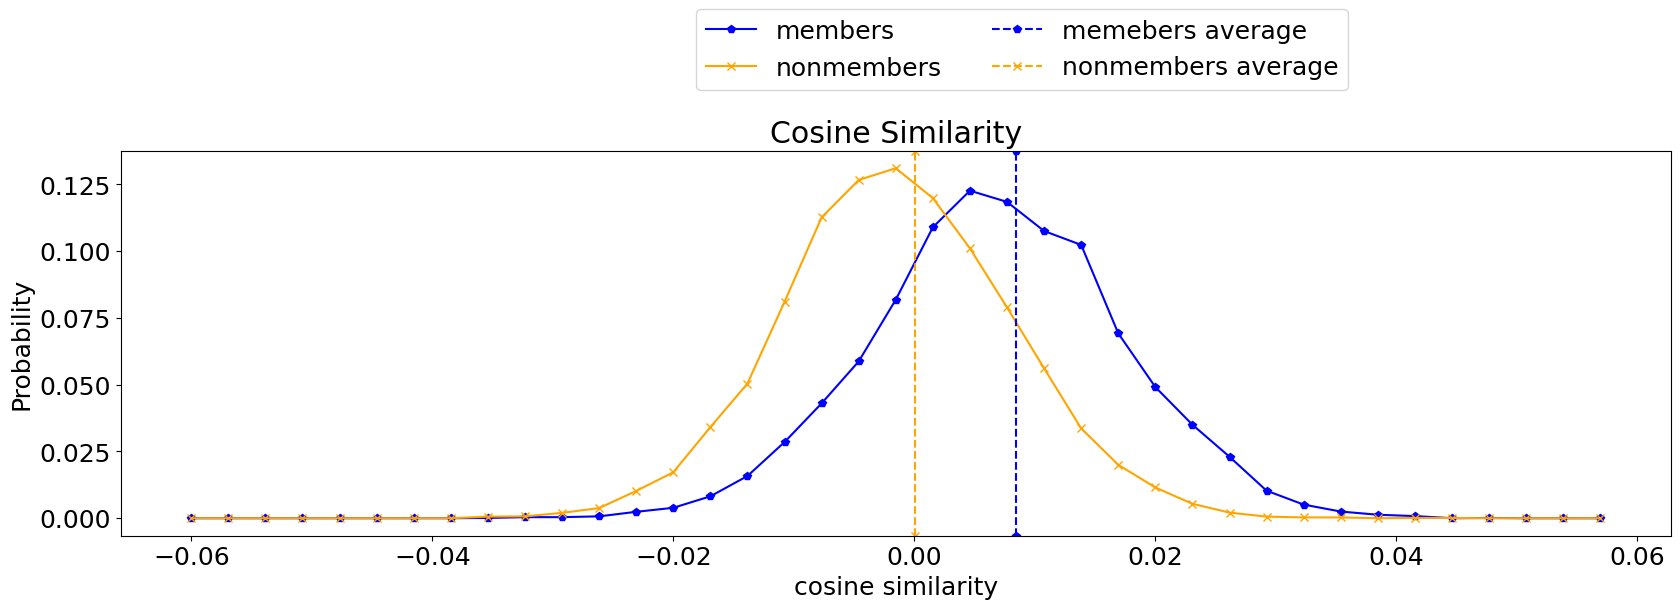

In [41]:

#fig = plt.figure(figsize=(30,5))
epochs = np.arange(199)+100
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar100','alexnet',1000,num_user=10,target_data_size=4000,lr_mul=0.0,num_layers=6,special_layers=[0,1,2,3,4,5,6])
#plt.savefig('std_proxy.pdf',dpi=800,bbox_inches='tight')

In [16]:

fig = plt.figure(figsize=(30,5))
epochs = (np.arange(29)+1)*10
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar100','alexnet',1000,num_user=10,target_data_size=4000,lr_mul=0.0,num_layers=6,special_layers=[0,1,2,3,4,5,6])
plt.savefig('std_proxy.pdf',dpi=800,bbox_inches='tight')

ValueError: could not broadcast input array from shape (20000,10,7) into shape (20000,10)

<Figure size 3000x500 with 0 Axes>

In [ ]:
epochs = (np.arange(29)+1)*10
print (epochs)
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar100','alexnet',1000,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

layer 0:
cosine acc 71.00000
combined acc  72.00000
avg non member std  0.00399
avg non member avg  0.00047
avg member std  0.00636
avg member avg  0.00408
avg max distance for layer 0:0.27300017
layer 2:
cosine acc 55.00000
combined acc  56.90000
avg non member std  0.02958
avg non member avg  -0.00258
avg member std  0.03012
avg member avg  0.00230
avg max distance for layer 2:0.06641294
layer 4:
cosine acc 56.70000
combined acc  58.70000
avg non member std  0.02344
avg non member avg  -0.00034
avg member std  0.02377
avg member avg  0.00409
avg max distance for layer 4:0.07455883
layer 6:
cosine acc 57.80000
combined acc  57.20000
avg non member std  0.03167
avg non member avg  0.00643
avg member std  0.03166
avg member avg  0.01241
avg max distance for layer 6:0.07623626


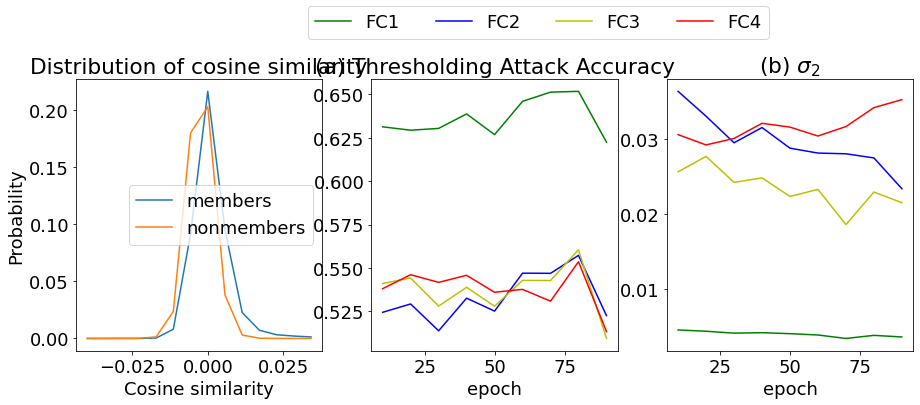

In [43]:
epochs = (np.arange(9)+1)*10
special_layers = [0,2,4,6]
all_analysis(epochs,prefix,'texas','texas',1000,num_layers=8,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360
 370 380 390 400 410 420 430 440 450 460 470 480 490]


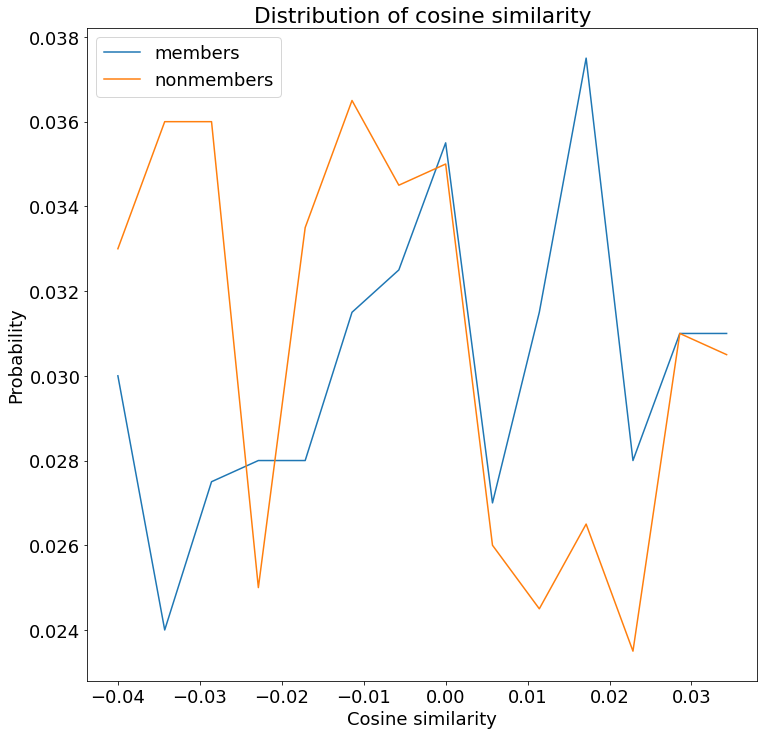

layer 0:
cosine acc 50.00000
combined acc  55.00000
avg non member std  0.11609
avg non member avg  0.00379
avg member std  0.12684
avg member avg  -0.00625
avg max distance for layer 0:0.05872762
layer 1:
cosine acc 49.00000
combined acc  47.00000
avg non member std  0.22548
avg non member avg  -0.00750
avg member std  0.23177
avg member avg  -0.00401
avg max distance for layer 1:0.04211519
layer 2:
cosine acc 53.00000
combined acc  59.00000
avg non member std  0.21902
avg non member avg  0.00108
avg member std  0.21813
avg member avg  0.00126
avg max distance for layer 2:0.04177455
layer 3:
cosine acc 57.00000
combined acc  49.00000
avg non member std  0.07667
avg non member avg  -0.00394
avg member std  0.07904
avg member avg  0.00062
avg max distance for layer 3:0.04371919
layer 4:
cosine acc 55.00000
combined acc  55.00000
avg non member std  0.21201
avg non member avg  -0.00621
avg member std  0.20164
avg member avg  0.00505
avg max distance for layer 4:0.04950995
layer 5:
cosine

avg member avg  0.00535
avg max distance for layer 162:0.06263617
layer 163:
cosine acc 51.00000
combined acc  51.00000
avg non member std  0.17466
avg non member avg  -0.00936
avg member std  0.17165
avg member avg  0.00321
avg max distance for layer 163:0.05676235
layer 164:
cosine acc 53.00000
combined acc  57.00000
avg non member std  0.16290
avg non member avg  -0.00584
avg member std  0.16046
avg member avg  -0.00358
avg max distance for layer 164:0.03194120
layer 165:
cosine acc 50.00000
combined acc  52.00000
avg non member std  0.06533
avg non member avg  0.00107
avg member std  0.06416
avg member avg  0.00541
avg max distance for layer 165:0.04779250
layer 166:
cosine acc 50.00000
combined acc  61.00000
avg non member std  0.11357
avg non member avg  0.00123
avg member std  0.11197
avg member avg  0.01013
avg max distance for layer 166:0.06025053
layer 167:
cosine acc 51.00000
combined acc  59.00000
avg non member std  0.09233
avg non member avg  0.00283
avg member std  0.093

avg non member avg  0.00670
avg member std  0.12789
avg member avg  0.00941
avg max distance for layer 282:0.04881547
layer 283:
cosine acc 49.00000
combined acc  51.00000
avg non member std  0.17295
avg non member avg  -0.00115
avg member std  0.17050
avg member avg  -0.00434
avg max distance for layer 283:0.03862763
layer 284:
cosine acc 50.00000
combined acc  54.00000
avg non member std  0.15744
avg non member avg  0.00007
avg member std  0.15746
avg member avg  0.00032
avg max distance for layer 284:0.03165280
layer 285:
cosine acc 48.00000
combined acc  59.00000
avg non member std  0.14758
avg non member avg  -0.00213
avg member std  0.14463
avg member avg  -0.00071
avg max distance for layer 285:0.03614114
layer 286:
cosine acc 50.00000
combined acc  51.00000
avg non member std  0.32081
avg non member avg  -0.01475
avg member std  0.32002
avg member avg  -0.00556
avg max distance for layer 286:0.03506203
layer 287:
cosine acc 54.00000
combined acc  58.00000
avg non member std  0.

IndexError: list index out of range

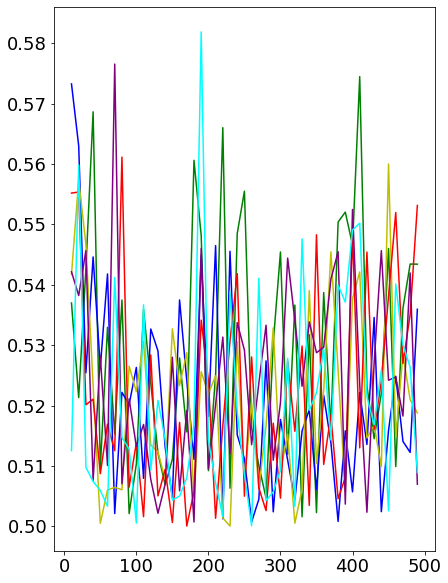

In [9]:
epochs = (np.arange(49)+1)*10
print (epochs)
special_layers = np.arange(299)
all_analysis(epochs,prefix,'cifar100','densenet_cifar',100,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers,num_layers=299)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290]


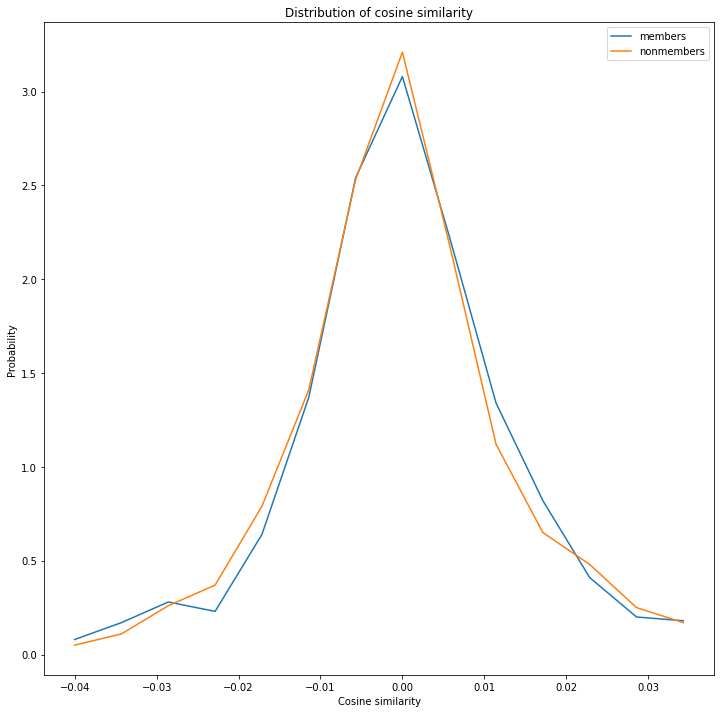

layer 0:
cosine acc 66.00000
combined acc  84.00000
avg non member std  0.10982
avg non member avg  0.01667
avg member std  0.10403
avg member avg  0.02345
avg max distance for layer 0:0.08279016
layer 2:
cosine acc 60.00000
combined acc  82.00000
avg non member std  0.05533
avg non member avg  0.01301
avg member std  0.05153
avg member avg  0.02063
avg max distance for layer 2:0.10294566
layer 4:
cosine acc 58.00000
combined acc  78.00000
avg non member std  0.04030
avg non member avg  0.01288
avg member std  0.03838
avg member avg  0.02024
avg max distance for layer 4:0.10591122
layer 6:
cosine acc 54.00000
combined acc  76.00000
avg non member std  0.02335
avg non member avg  0.00783
avg member std  0.02379
avg member avg  0.01068
avg max distance for layer 6:0.08538488
layer 8:
cosine acc 64.00000
combined acc  84.00000
avg non member std  0.01704
avg non member avg  0.00350
avg member std  0.01762
avg member avg  0.00398
avg max distance for layer 8:0.08268757
layer 10:
cosine acc

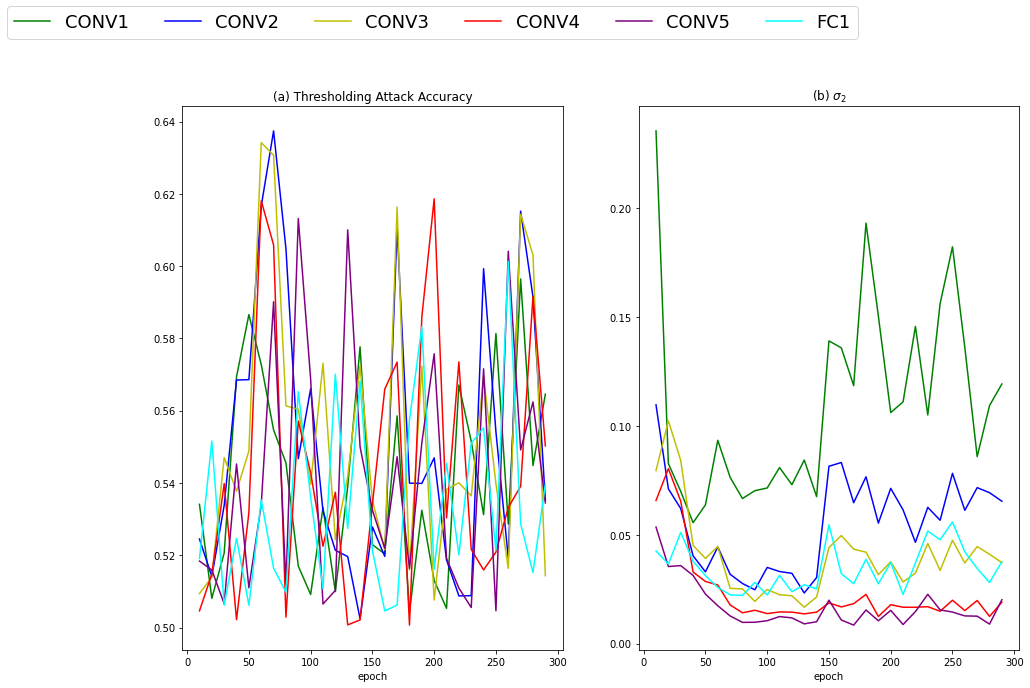

In [6]:
epochs = (np.arange(29)+1)*10
print (epochs)
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar100','alexnet',50,num_user=1,target_data_size=4000,lr_mul=-1.0,special_layers=special_layers)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290]


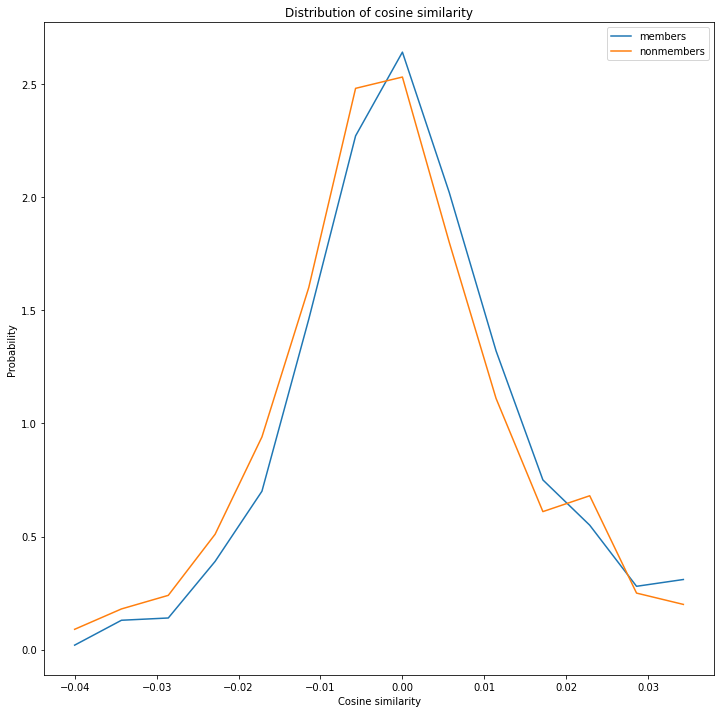

layer 0:
cosine acc 64.00000
combined acc  96.00000
avg non member std  0.11394
avg non member avg  0.00820
avg member std  0.10791
avg member avg  0.01756
avg max distance for layer 0:0.08641627
layer 2:
cosine acc 70.00000
combined acc  100.00000
avg non member std  0.06210
avg non member avg  0.00823
avg member std  0.06083
avg member avg  0.02105
avg max distance for layer 2:0.12174268
layer 4:
cosine acc 68.00000
combined acc  90.00000
avg non member std  0.04766
avg non member avg  0.01165
avg member std  0.04836
avg member avg  0.02385
avg max distance for layer 4:0.14389044
layer 6:
cosine acc 70.00000
combined acc  94.00000
avg non member std  0.02911
avg non member avg  0.01200
avg member std  0.02882
avg member avg  0.01744
avg max distance for layer 6:0.11334065
layer 8:
cosine acc 58.00000
combined acc  94.00000
avg non member std  0.01853
avg non member avg  0.00632
avg member std  0.01952
avg member avg  0.00979
avg max distance for layer 8:0.08176503
layer 10:
cosine ac

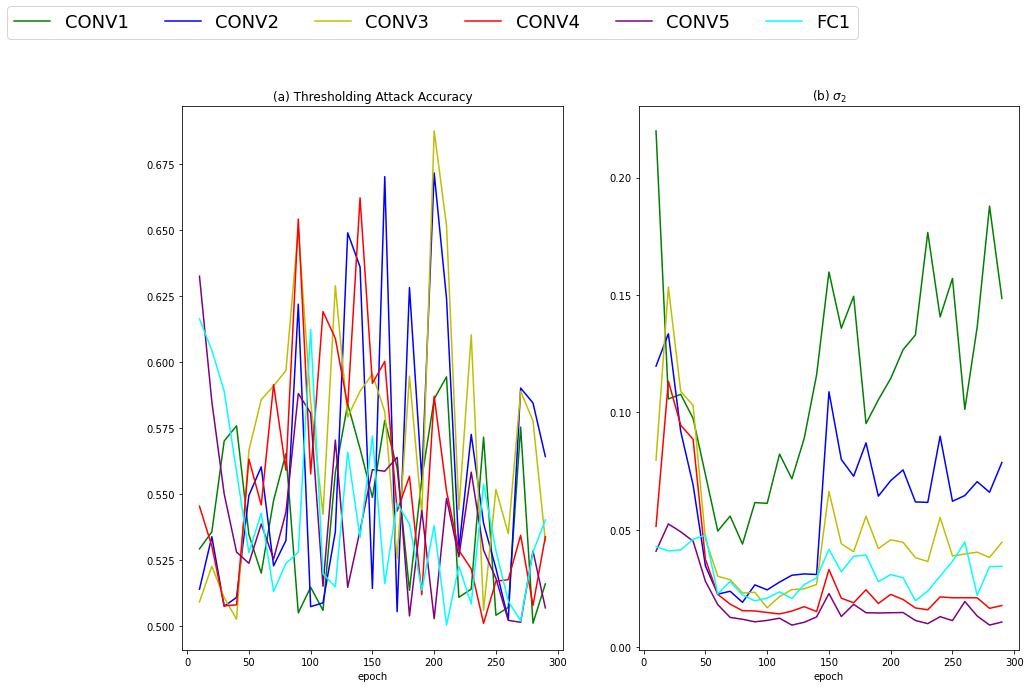

In [7]:
epochs = (np.arange(29)+1)*10
print (epochs)
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar100','alexnet',50,num_user=1,target_data_size=4000,lr_mul=1.0,special_layers=special_layers)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290]


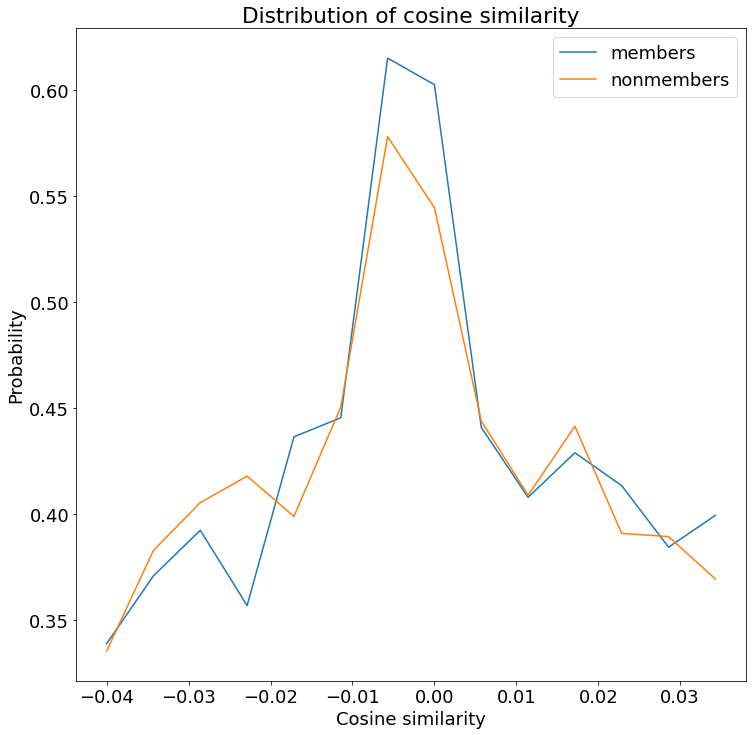

layer 0:
cosine acc 57.80000
combined acc  76.80000
avg non member std  0.08191
avg non member avg  0.00427
avg member std  0.08056
avg member avg  0.00908
avg max distance for layer 0:0.03308912
layer 2:
cosine acc 63.00000
combined acc  77.90000
avg non member std  0.03135
avg non member avg  0.00176
avg member std  0.03062
avg member avg  0.00425
avg max distance for layer 2:0.05317233
layer 4:
cosine acc 56.00000
combined acc  78.10000
avg non member std  0.02579
avg non member avg  0.00146
avg member std  0.02552
avg member avg  0.00278
avg max distance for layer 4:0.03212682
layer 6:
cosine acc 57.60000
combined acc  77.70000
avg non member std  0.03648
avg non member avg  0.00296
avg member std  0.03580
avg member avg  0.00490
avg max distance for layer 6:0.02857409
layer 8:
cosine acc 63.50000
combined acc  76.20000
avg non member std  0.08790
avg non member avg  0.00580
avg member std  0.08626
avg member avg  0.01009
avg max distance for layer 8:0.02565628
layer 10:
cosine acc

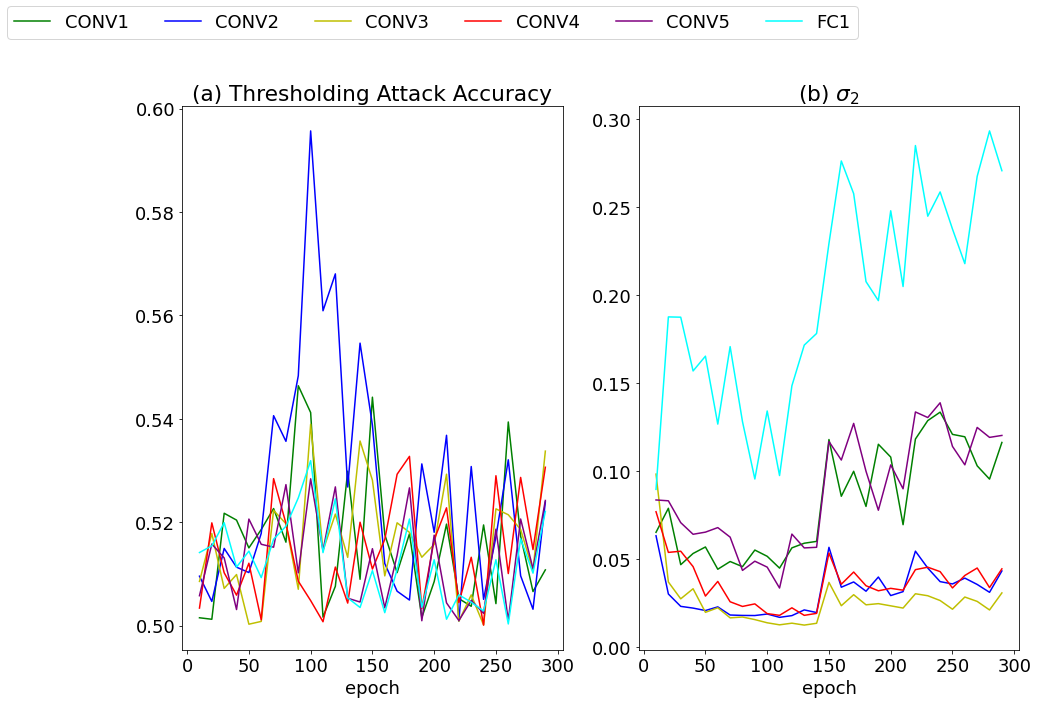

In [33]:
epochs = (np.arange(29)+1)*10
print (epochs)
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar10','alexnet',1000,num_user=1,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290]


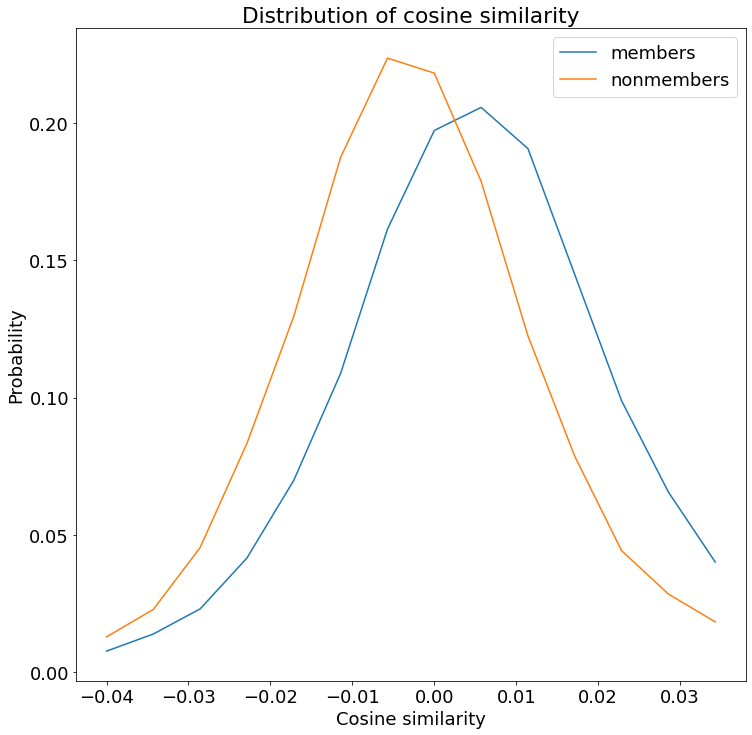

layer 0:
cosine acc 53.20000
combined acc  64.40000
avg non member std  0.10779
avg non member avg  0.00317
avg member std  0.10748
avg member avg  0.01366
avg max distance for layer 0:0.03621923
layer 2:
cosine acc 59.40000
combined acc  67.50000
avg non member std  0.04441
avg non member avg  0.00339
avg member std  0.04354
avg member avg  0.01342
avg max distance for layer 2:0.08929977
layer 4:
cosine acc 63.60000
combined acc  71.50000
avg non member std  0.03768
avg non member avg  0.00188
avg member std  0.03659
avg member avg  0.01281
avg max distance for layer 4:0.12428403
layer 6:
cosine acc 67.40000
combined acc  70.40000
avg non member std  0.02414
avg non member avg  0.00120
avg member std  0.02416
avg member avg  0.01077
avg max distance for layer 6:0.17360892
layer 8:
cosine acc 67.50000
combined acc  73.20000
avg non member std  0.01645
avg non member avg  0.00069
avg member std  0.01758
avg member avg  0.00850
avg max distance for layer 8:0.20747926
layer 10:
cosine acc

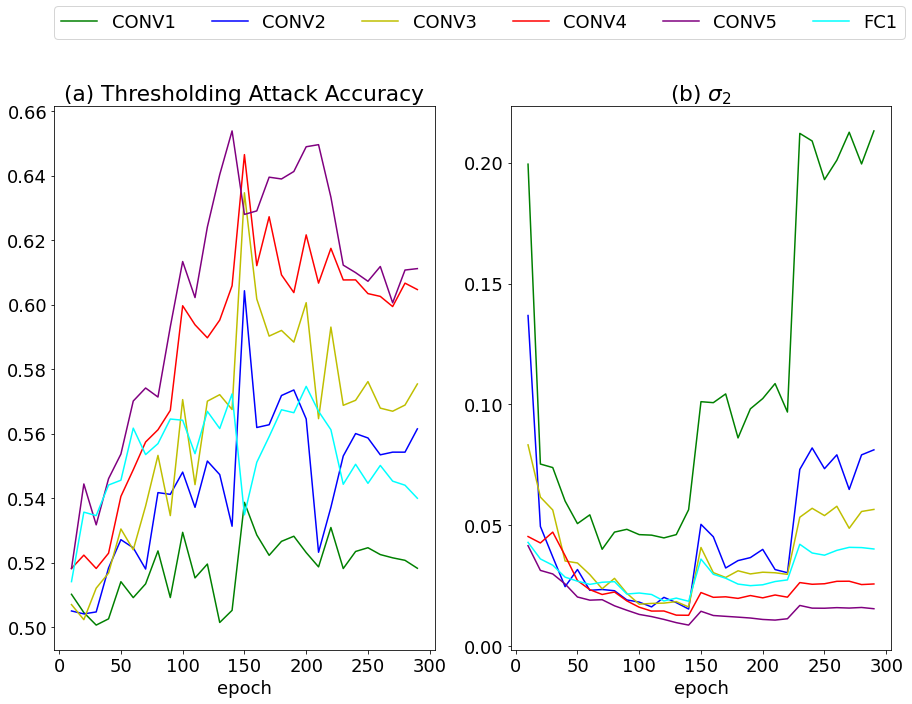

In [15]:
epochs = (np.arange(29)+1)*10
print (epochs)
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar100','alexnet',1000,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290]


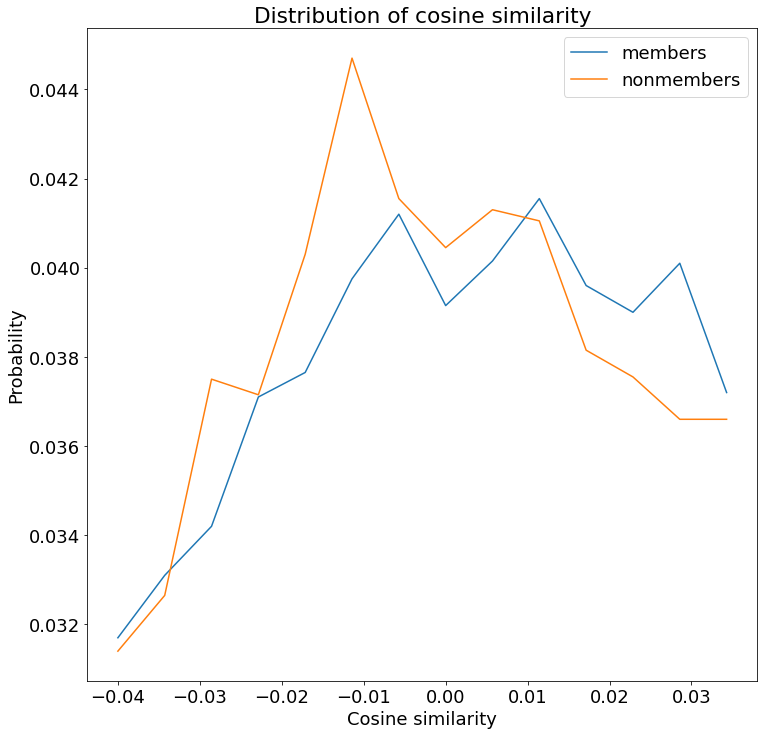

layer 0:
cosine acc 53.00000
combined acc  55.00000
avg non member std  0.06198
avg non member avg  0.00213
avg member std  0.06175
avg member avg  0.00587
avg max distance for layer 0:0.02455065
layer 2:
cosine acc 56.70000
combined acc  57.90000
avg non member std  0.02319
avg non member avg  0.00033
avg member std  0.02322
avg member avg  0.00390
avg max distance for layer 2:0.06249234
layer 4:
cosine acc 55.90000
combined acc  60.10000
avg non member std  0.02261
avg non member avg  0.00029
avg member std  0.02317
avg member avg  0.00349
avg max distance for layer 4:0.06155778
layer 6:
cosine acc 56.10000
combined acc  57.70000
avg non member std  0.03383
avg non member avg  0.00123
avg member std  0.03420
avg member avg  0.00563
avg max distance for layer 6:0.05459640
layer 8:
cosine acc 53.30000
combined acc  55.60000
avg non member std  0.08546
avg non member avg  0.00534
avg member std  0.08621
avg member avg  0.01401
avg max distance for layer 8:0.03914092
layer 10:
cosine acc

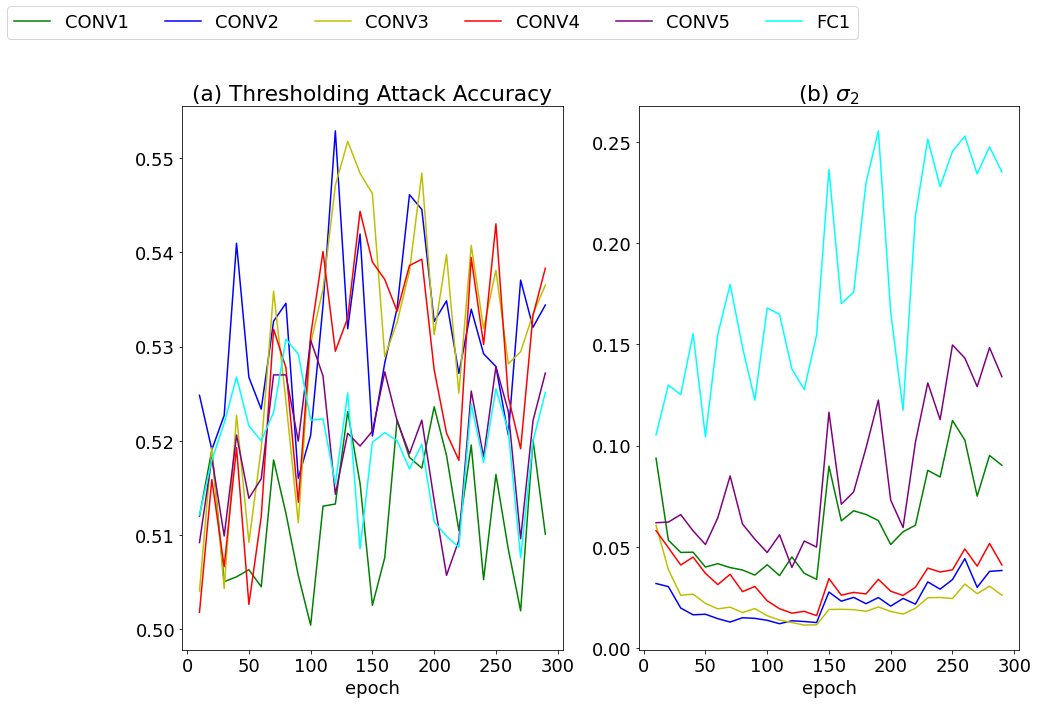

In [24]:
epochs = (np.arange(29)+1)*10
print (epochs)
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar10','alexnet',1000,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

layer 0:
cosine acc 57.20000
combined acc  60.80000
avg non member std  0.01457
avg non member avg  0.00009
avg member std  0.01645
avg member avg  0.00398
avg max distance for layer 0:0.09993273
layer 2:
cosine acc 58.30000
combined acc  60.90000
avg non member std  0.02105
avg non member avg  0.00070
avg member std  0.02220
avg member avg  0.00479
avg max distance for layer 2:0.07647231
layer 4:
cosine acc 56.80000
combined acc  56.50000
avg non member std  0.02531
avg non member avg  0.00126
avg member std  0.02543
avg member avg  0.00388
avg max distance for layer 4:0.05904339
layer 6:
cosine acc 51.90000
combined acc  57.50000
avg non member std  0.04414
avg non member avg  0.00706
avg member std  0.04334
avg member avg  0.00975
avg max distance for layer 6:0.02619938


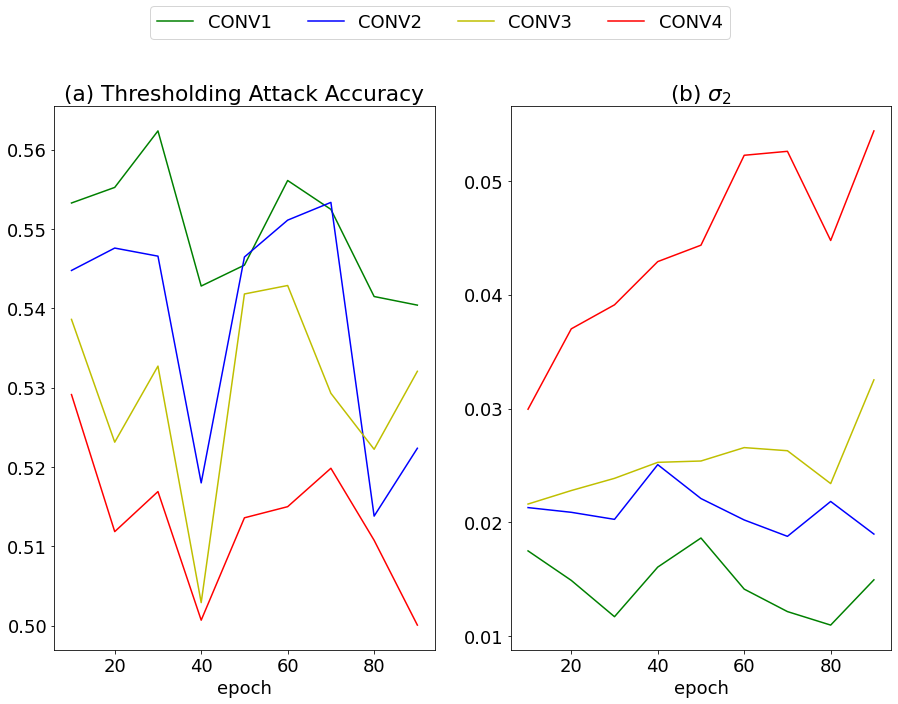

In [26]:
epochs = (np.arange(9)+1)*10
special_layers = [0,2,4,6]
all_analysis(epochs,prefix,'purchase','purchase',1000,num_layers=8,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290]


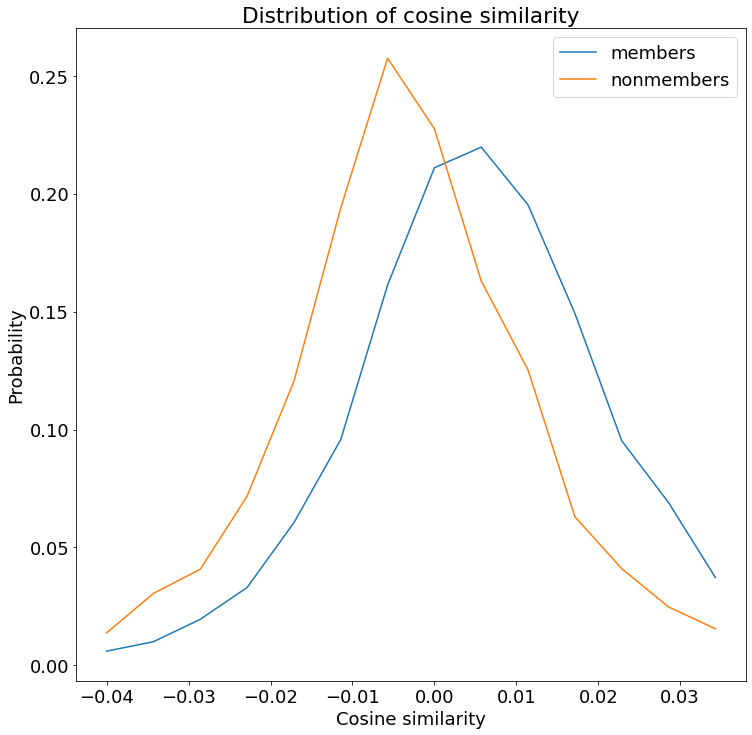

layer 0:
cosine acc 56.50000
combined acc  64.50000
avg non member std  0.09864
avg non member avg  0.00495
avg member std  0.09748
avg member avg  0.01923
avg max distance for layer 0:0.05572050
layer 2:
cosine acc 59.00000
combined acc  66.00000
avg non member std  0.04497
avg non member avg  -0.00065
avg member std  0.04445
avg member avg  0.01157
avg max distance for layer 2:0.10265090
layer 4:
cosine acc 58.00000
combined acc  68.50000
avg non member std  0.04257
avg non member avg  0.00133
avg member std  0.04229
avg member avg  0.01333
avg max distance for layer 4:0.11615515
layer 6:
cosine acc 69.00000
combined acc  70.50000
avg non member std  0.02702
avg non member avg  0.00254
avg member std  0.02812
avg member avg  0.01310
avg max distance for layer 6:0.16505570
layer 8:
cosine acc 73.50000
combined acc  73.00000
avg non member std  0.01611
avg non member avg  0.00031
avg member std  0.01713
avg member avg  0.00945
avg max distance for layer 8:0.25261780
layer 10:
cosine ac

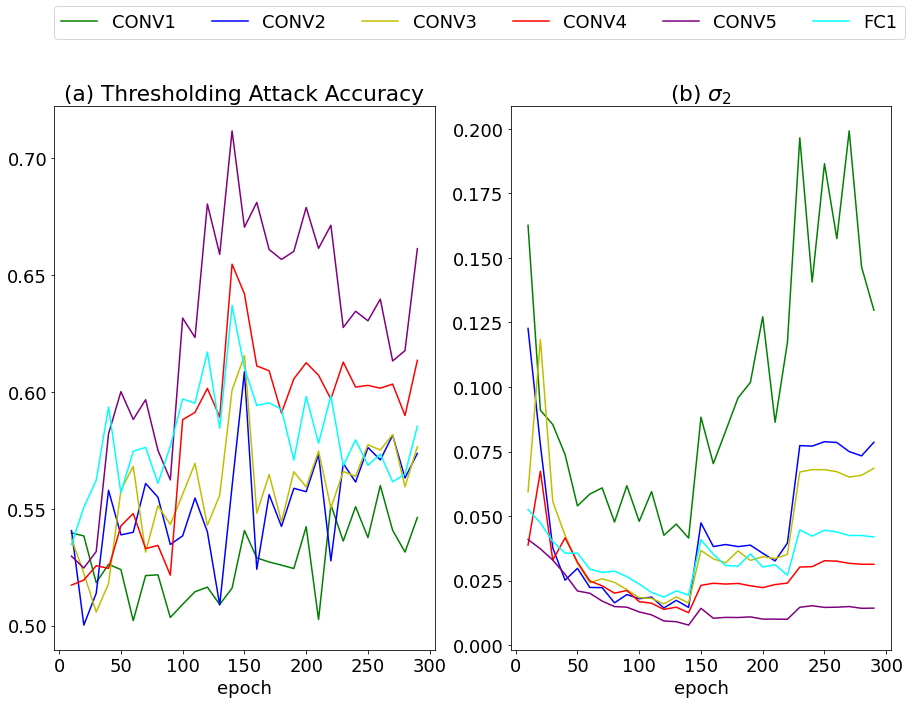

In [105]:
epochs = (np.arange(29)+1)*10
print (epochs)
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar100','alexnet',200,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

layer 0:
cosine acc 62.00000
combined acc  62.00000
avg non member std  0.02563
avg non member avg  -0.00045
avg member std  0.02664
avg member avg  0.00474
avg max distance for layer 0:0.08896294
layer 2:
cosine acc 59.50000
combined acc  64.50000
avg non member std  0.03359
avg non member avg  0.00085
avg member std  0.03433
avg member avg  0.00765
avg max distance for layer 2:0.08391625
layer 4:
cosine acc 59.00000
combined acc  59.50000
avg non member std  0.03326
avg non member avg  0.00165
avg member std  0.03223
avg member avg  0.01063
avg max distance for layer 4:0.10850501
layer 6:
cosine acc 56.00000
combined acc  64.50000
avg non member std  0.05673
avg non member avg  0.00265
avg member std  0.05151
avg member avg  0.01194
avg max distance for layer 6:0.06606040


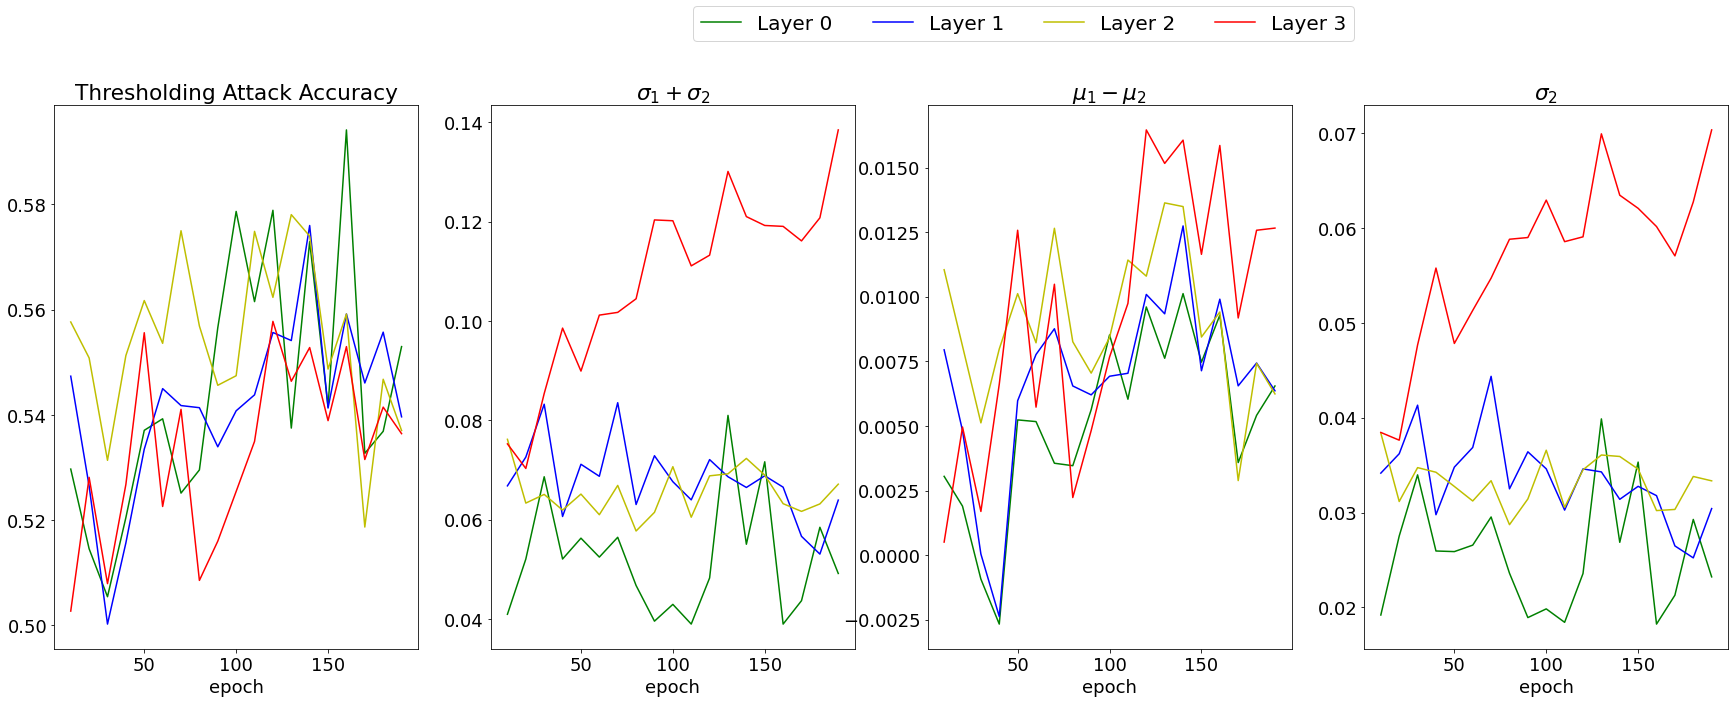

In [63]:
epochs = (np.arange(19)+1)*10
special_layers = [0,2,4,6]
all_analysis(epochs,prefix,'purchase','purchase',200,num_layers=8,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

In [2]:
special_layers = [0,2,4,6]
epochs = (np.arange(9)+1)*10
all_analysis(epochs,prefix,'texas','texas',200,num_layers=8,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

#special_layers = [0,2,4,6]
#epochs = (np.arange(9)+1)*10
#all_analysis(epochs,prefix,'texas','texas',50,num_layers=8,num_user=10,target_data_size=2000,lr_mul=-1000.0,special_layers=special_layers)

#special_layers = [0,2,4,6]
#epochs = (np.arange(9)+1)*10
#all_analysis(epochs,prefix,'texas','texas',50,num_layers=8,num_user=10,target_data_size=2000,lr_mul=1.0,special_layers=special_layers)

NameError: name 'prefix' is not defined

In [ ]:
epochs = (np.arange(29)+1)*10
print (epochs)
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar100','alexnet',100,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

In [6]:
epochs = (np.arange(29)+1)*10
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar100','alexnet',300,num_user=10,target_data_size=4000,lr_mul=0.0,special_layers=special_layers)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/expdata/all_info_multi_party_member_attack_0_server_0_0.0_10_20_0_0.0_0.0_0_0.0_0_0_11_cifar100_4000_300_alexnet.npy'

Suppose we know the distributions of cosine similarity for members and non-members, say $$p(\mu_1,\sigma_1)$$ and $$q(\mu_2,\sigma_2)$$. To tell how differentiable p and q are, we define a new metric D :

$$ \int \frac{max(p(x),q(x))}{(p(x)+q(x))}*\frac{p(x)+q(x)}{2} dx $$

Assume we know these two distributions, given a sample x, we want to guess with maximum winning probability. Basically, the larger D is, the higher attack accuracy we can get. If the adversary happens to know a few member instances, then the adversary can use this metric D to find the best layer. If we assume p and q are normal distributions and the mean of p is smaller than q, then we can have 

$$ D = \frac{(cdf(p,x) + 1 - cdf(q,x))}{2} $$, where x is the intersection. There are actually two intersection, and we need to choose the one in the middle of the two peaks.

$ x = \frac{\sigma_1*\mu_2+\sigma_2*\mu_1}{\sigma_1+\sigma_2}$ is the intersection. If we take this x into the cdf function, then we have $ 2D = (1 + 0.5*( erf(\frac{x-\mu_1}{\sigma_1*\sqrt{2}}) - erf(\frac{x-\mu_2}{\sigma_2*\sqrt{2}}))) $, which is actually $2D = (1 + erf(\frac{\mu_2-\mu_1}{(\sigma_1 + \sigma_2)*\sqrt{2}})) $.

If no member instance can be used, then we only know $\mu_1, \sigma_1$, as the avg cosine of non-members is smaller than the avg cosine of members and we need to maximize $ \frac{\mu_2 - \mu_1}{\sigma_1+\sigma_2}$. So, smaller $\mu_1,\sigma_1$ would be preferred. One obvservation here is $\sigma_1 \approx \sigma_2$ and another observation is the magnitude of difference of $\sigma_1$ for different layers is around 5x to 10x of the magnitude of difference of $ \mu_1$, plus that $\mu_1$ is linearly related to $D$ but $\sigma_1$ is not. Thus, one rule of thumb is to choose the layer with the smallest $\sigma_1$.

<!--- Basically, if we want to find the best layer, we need to maximize $$\frac{x-\mu_1}{\sigma_1*\sqrt{2}} - \frac{x-\mu_2}{\sigma_2*\sqrt{2}}$$ and . 

Another metric is called Bhattacharyya distance, where
$$ D_{bhat} = \int (p(x)*q(x))^{0.5} dx $$ 
This distance is to measure the amount of overlap between two statistical samples or population. The smaller $$D_{bhat}$$ is, the better the layer is. However, estimating this distance is actually hard because the normal distribution is quite narrow.
.--->


[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290]


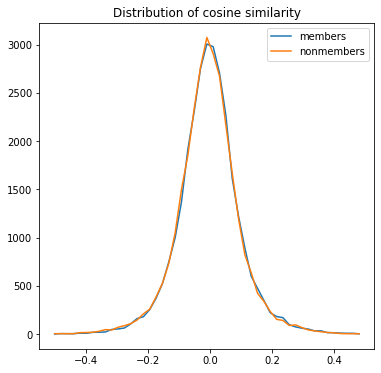

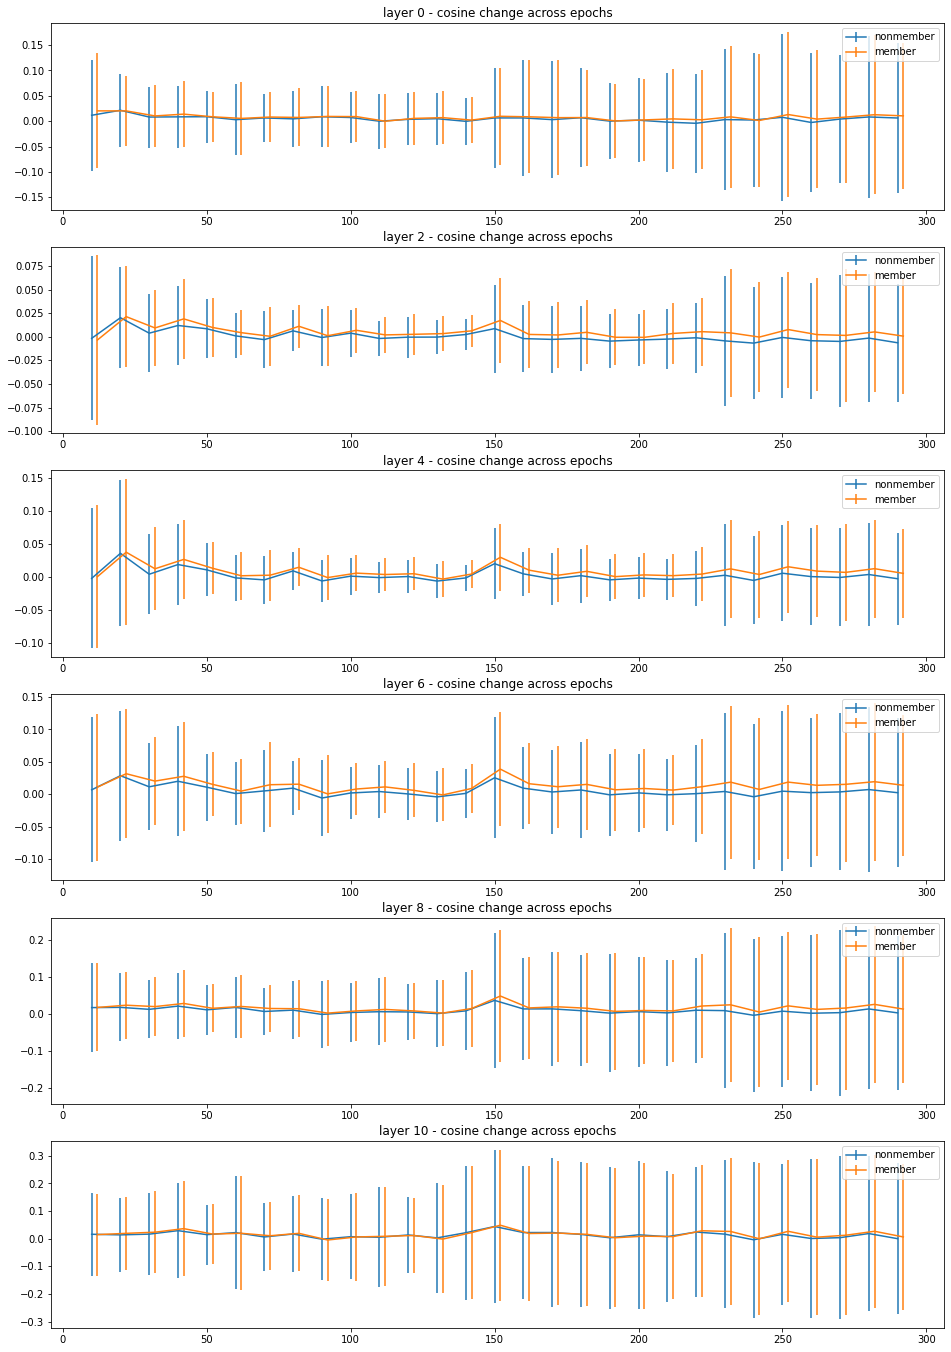

layer 0:
cosine acc 50.73000
combined acc  52.86750
avg non member std  0.09054
avg non member avg  0.00497
avg member std  0.09018
avg member avg  0.00786
avg max distance for layer 0:0.01332661
layer 2:
cosine acc 55.64000
combined acc  55.62750
avg non member std  0.04116
avg non member avg  0.00055
avg member std  0.04097
avg member avg  0.00530
avg max distance for layer 2:0.05268882
layer 4:
cosine acc 54.95500
combined acc  55.70750
avg non member std  0.04991
avg non member avg  0.00217
avg member std  0.04979
avg member avg  0.00826
avg max distance for layer 4:0.05574980
layer 6:
cosine acc 54.53750
combined acc  54.70750
avg non member std  0.07629
avg non member avg  0.00548
avg member std  0.07495
avg member avg  0.01372
avg max distance for layer 6:0.04600511
layer 8:
cosine acc 51.65250
combined acc  52.88500
avg non member std  0.13524
avg non member avg  0.00924
avg member std  0.13310
avg member avg  0.01615
avg max distance for layer 8:0.02095256
layer 10:
cosine acc

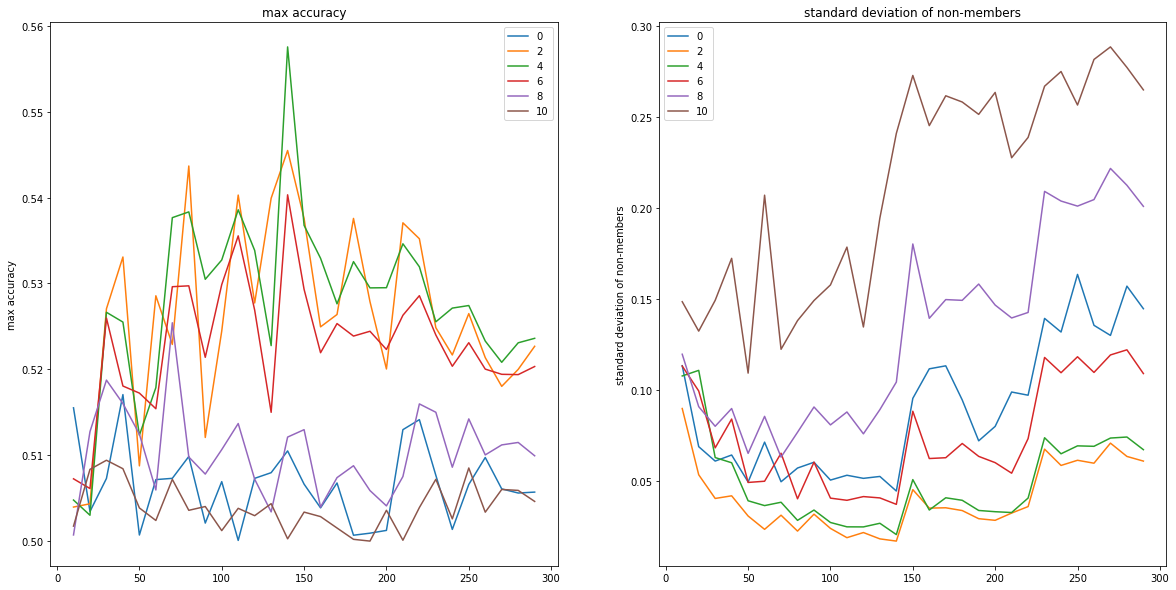

In [5]:
epochs = (np.arange(29)+1)*10
print (epochs)
special_layers = [0,2,4,6,8,10]
all_analysis(epochs,prefix,'cifar10','alexnet',1000,num_user=10,target_data_size=2000,lr_mul=0.0,special_layers=special_layers)

In [51]:
all_analysis(epochs,prefix,'cifar100','alexnet',200,num_user=10,target_data_size=2000,lr_mul=0.0,special_layers=special_layers)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/expdata/all_info_multi_party_member_attack_0_server_0_0.0_10_20_0_0.0_0.0_0_0.0_0_0_11_cifar100_2000_200_alexnet.npy'

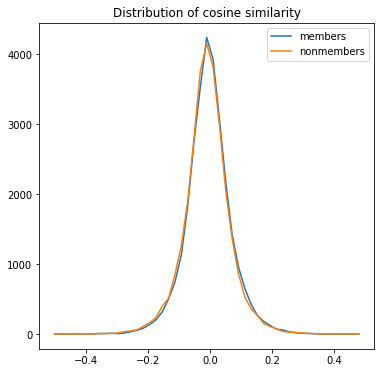

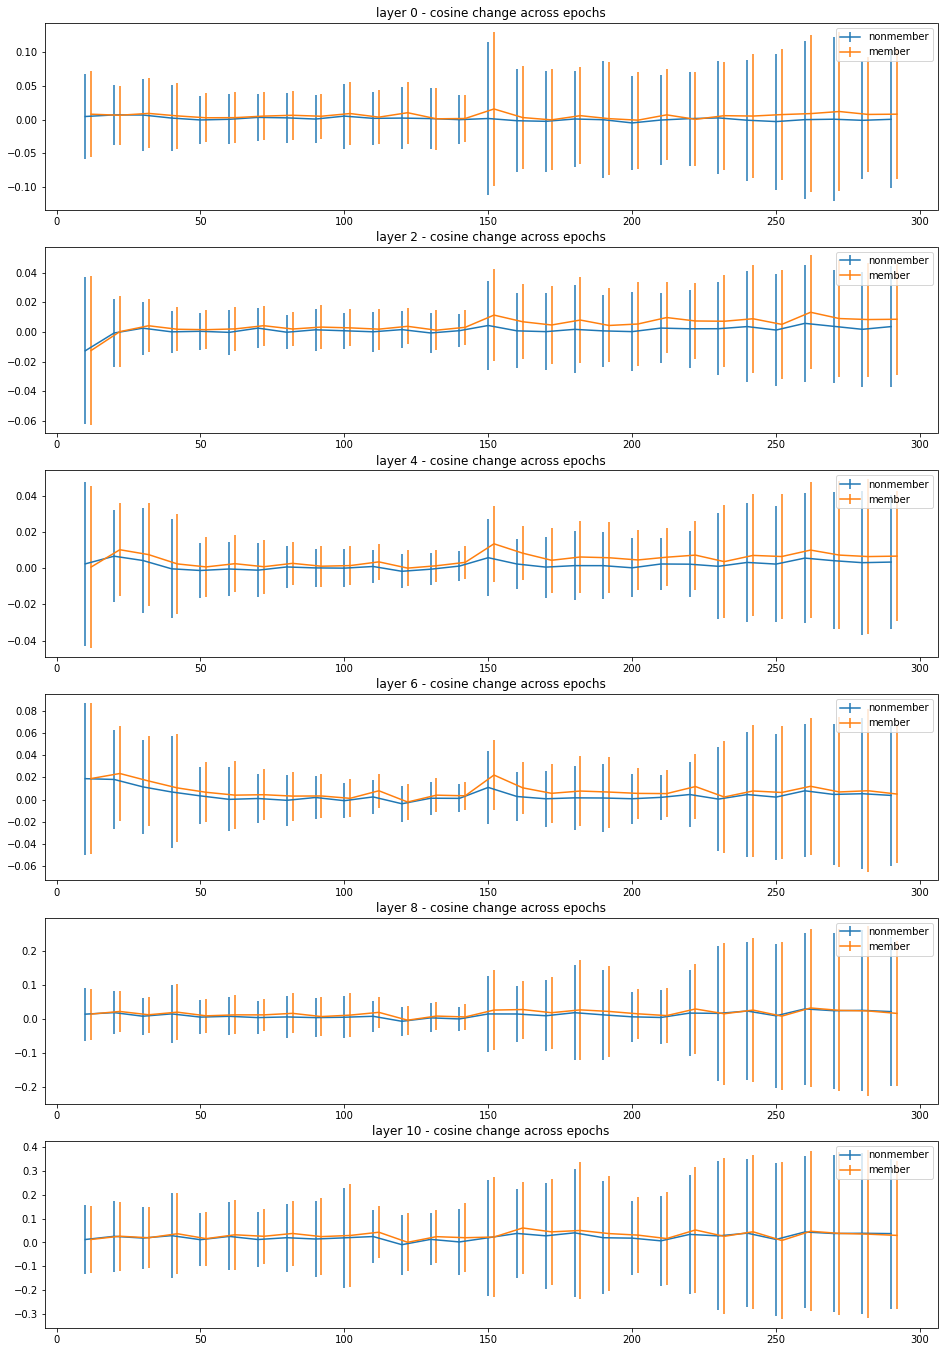

layer 0:
cosine acc 52.92750
combined acc  65.03750
avg non member std  0.06668
avg non member avg  0.00098
avg member std  0.06606
avg member avg  0.00560
avg max distance for layer 0:0.02777547
layer 2:
cosine acc 56.57250
combined acc  65.75500
avg non member std  0.02441
avg non member avg  0.00103
avg member std  0.02447
avg member avg  0.00472
avg max distance for layer 2:0.06142678
layer 4:
cosine acc 59.23750
combined acc  66.36500
avg non member std  0.02143
avg non member avg  0.00166
avg member std  0.02227
avg member avg  0.00481
avg max distance for layer 4:0.06966512
layer 6:
cosine acc 59.90500
combined acc  65.73250
avg non member std  0.03563
avg non member avg  0.00390
avg member std  0.03651
avg member avg  0.00787
avg max distance for layer 6:0.05652778
layer 8:
cosine acc 59.17750
combined acc  65.67000
avg non member std  0.10875
avg non member avg  0.01259
avg member std  0.11094
avg member avg  0.01777
avg max distance for layer 8:0.03142323
layer 10:
cosine acc

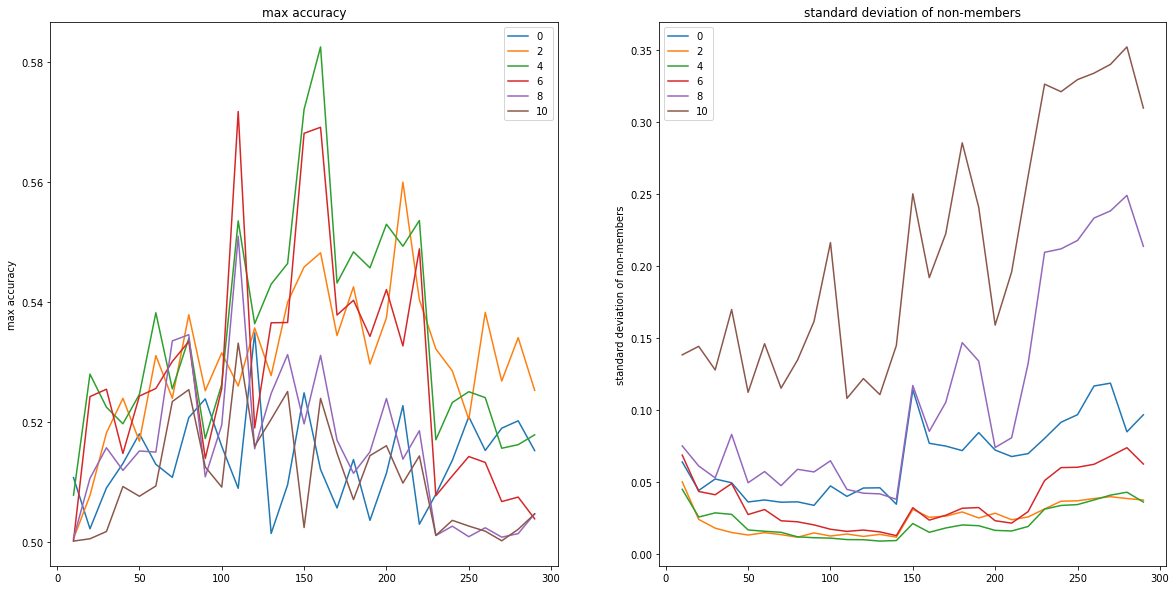

In [7]:
all_analysis(epochs,prefix,'cifar10','alexnet',1000,num_user=4,target_data_size=5000,lr_mul=0.0,special_layers=special_layers)

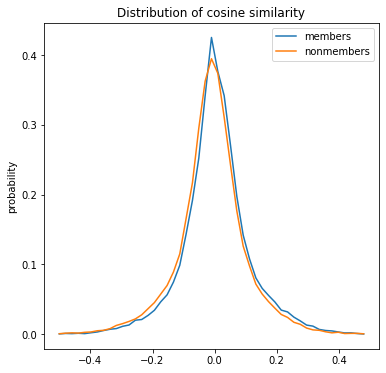

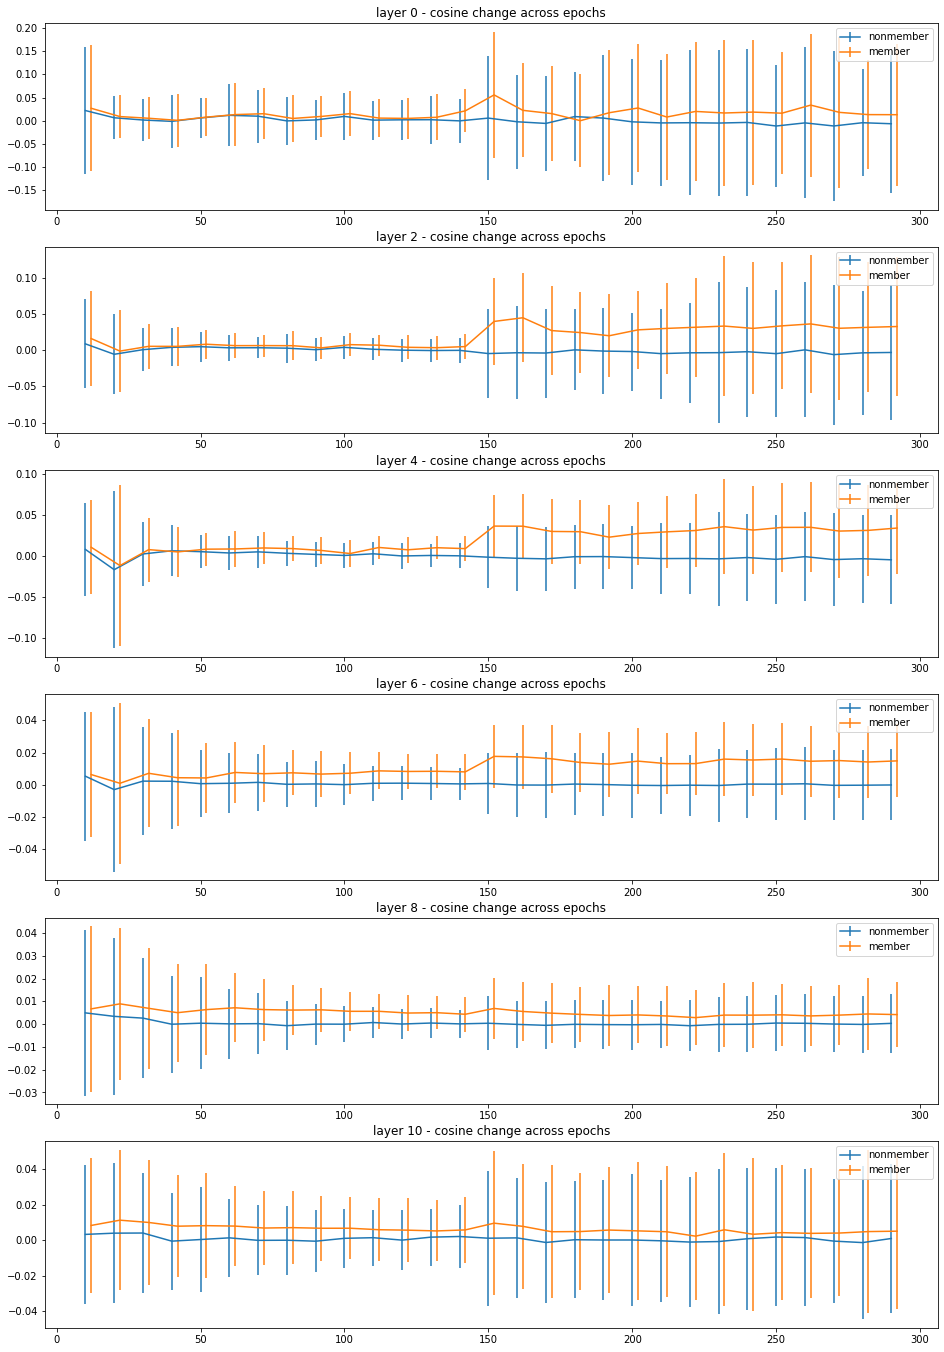

layer 0:
cosine acc 60.80000
combined acc  83.40000
avg non member std  0.09739
avg non member avg  0.00074
avg member std  0.09697
avg member avg  0.01515
avg max distance for layer 0:0.05714888
layer 2:
cosine acc 68.00000
combined acc  85.00000
avg non member std  0.05087
avg non member avg  -0.00063
avg member std  0.05131
avg member avg  0.01919
avg max distance for layer 2:0.13320642
layer 4:
cosine acc 73.60000
combined acc  86.60000
avg non member std  0.03761
avg non member avg  -0.00089
avg member std  0.03801
avg member avg  0.01930
avg max distance for layer 4:0.20386520
layer 6:
cosine acc 72.30000
combined acc  86.80000
avg non member std  0.02077
avg non member avg  0.00052
avg member std  0.02112
avg member avg  0.01093
avg max distance for layer 6:0.21877316
layer 8:
cosine acc 72.90000
combined acc  87.80000
avg non member std  0.01360
avg non member avg  0.00043
avg member std  0.01475
avg member avg  0.00519
avg max distance for layer 8:0.15885603
layer 10:
cosine a

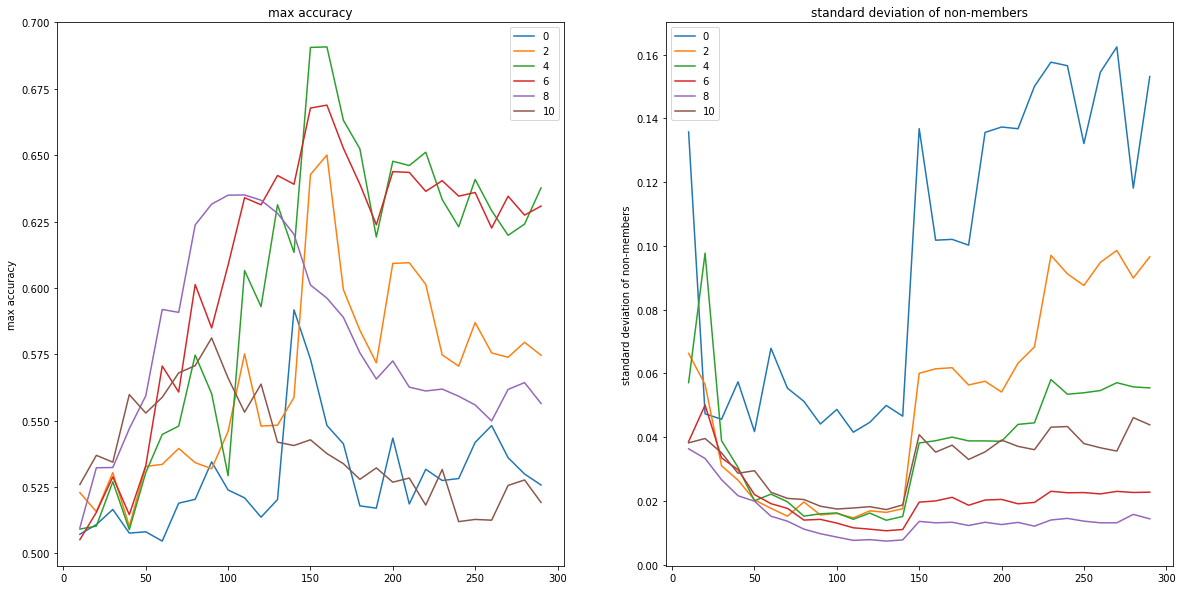

In [15]:
all_analysis(epochs,prefix,'cifar100','alexnet',1000,num_user=4,target_data_size=5000,lr_mul=0.0,special_layers=special_layers)

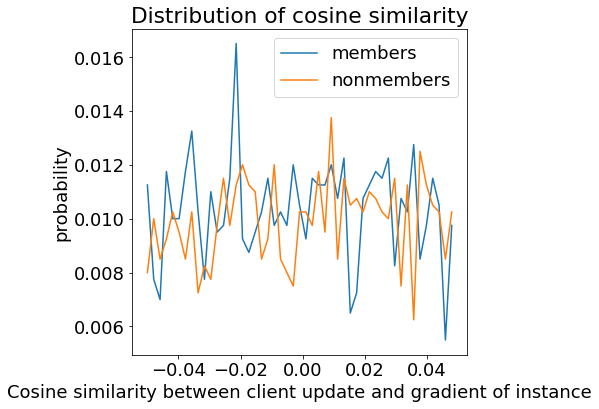

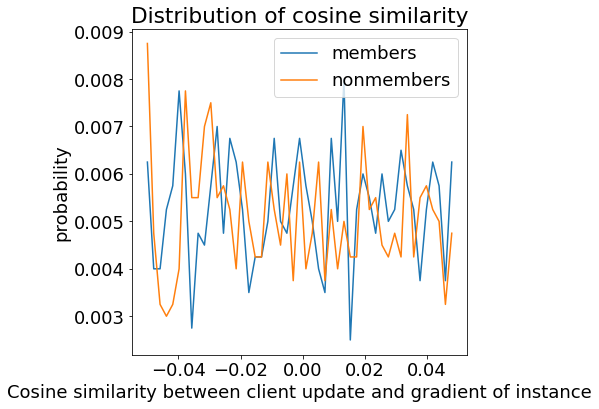

ValueError: Image size of 1152x86112 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1152x86112 with 299 Axes>

layer 0:
cosine acc 56.00000
combined acc  52.00000
avg non member std  0.13914
avg non member avg  0.00040
avg member std  0.13968
avg member avg  0.00262
avg max distance for layer 0:0.03619907
layer 1:
cosine acc 59.00000
combined acc  54.00000
avg non member std  0.25041
avg non member avg  -0.00521
avg member std  0.24626
avg member avg  0.01215
avg max distance for layer 1:0.04715700
layer 2:
cosine acc 54.50000
combined acc  51.50000
avg non member std  0.22816
avg non member avg  0.00130
avg member std  0.22398
avg member avg  0.01025
avg max distance for layer 2:0.04384248
layer 3:
cosine acc 50.50000
combined acc  53.50000
avg non member std  0.09469
avg non member avg  0.00176
avg member std  0.09413
avg member avg  0.00922
avg max distance for layer 3:0.03909628
layer 4:
cosine acc 53.00000
combined acc  53.00000
avg non member std  0.21139
avg non member avg  -0.00200
avg member std  0.21007
avg member avg  -0.00223
avg max distance for layer 4:0.03050721
layer 5:
cosine a

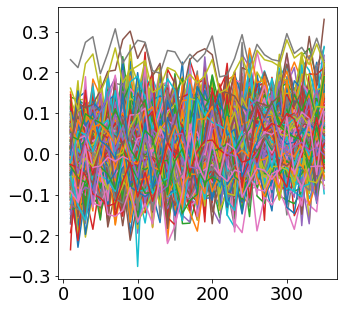

loss acc: 60.0
max amount of change for avg of nonmember's cos 0.04468782927557602
max amount of change for std of nonmember's cos 0.24150009229347041
[[0.52722949 0.51035493 0.5082692  ... 0.52675061 0.53420699 0.52519212]
 [0.50112519 0.50899249 0.52865946 ... 0.51402331 0.53484681 0.55462552]
 [0.50750026 0.52278691 0.50637915 ... 0.57257177 0.55260758 0.53754865]
 ...
 [0.52573764 0.53338547 0.50548157 ... 0.52341854 0.51439086 0.52930046]
 [0.56489554 0.55946859 0.57672297 ... 0.56533407 0.5795228  0.56427016]
 [0.54536533 0.53089058 0.56214754 ... 0.56157235 0.5755867  0.56183102]]
[[0.53069485 0.51168262 0.50932995 ... 0.53015606 0.53853832 0.52840223]
 [0.50126964 0.51014584 0.53230336 ... 0.51581946 0.53925684 0.56139394]
 [0.50846251 0.52569448 0.50719771 ... 0.58131705 0.55914297 0.5422896 ]
 ...
 [0.52901618 0.53761556 0.50618504 ... 0.52640569 0.51623386 0.53302422]
 [0.57281766 0.56678804 0.58589791 ... 0.57330417 0.58898097 0.57212367]
 [0.55104918 0.53481199 0.56976652 

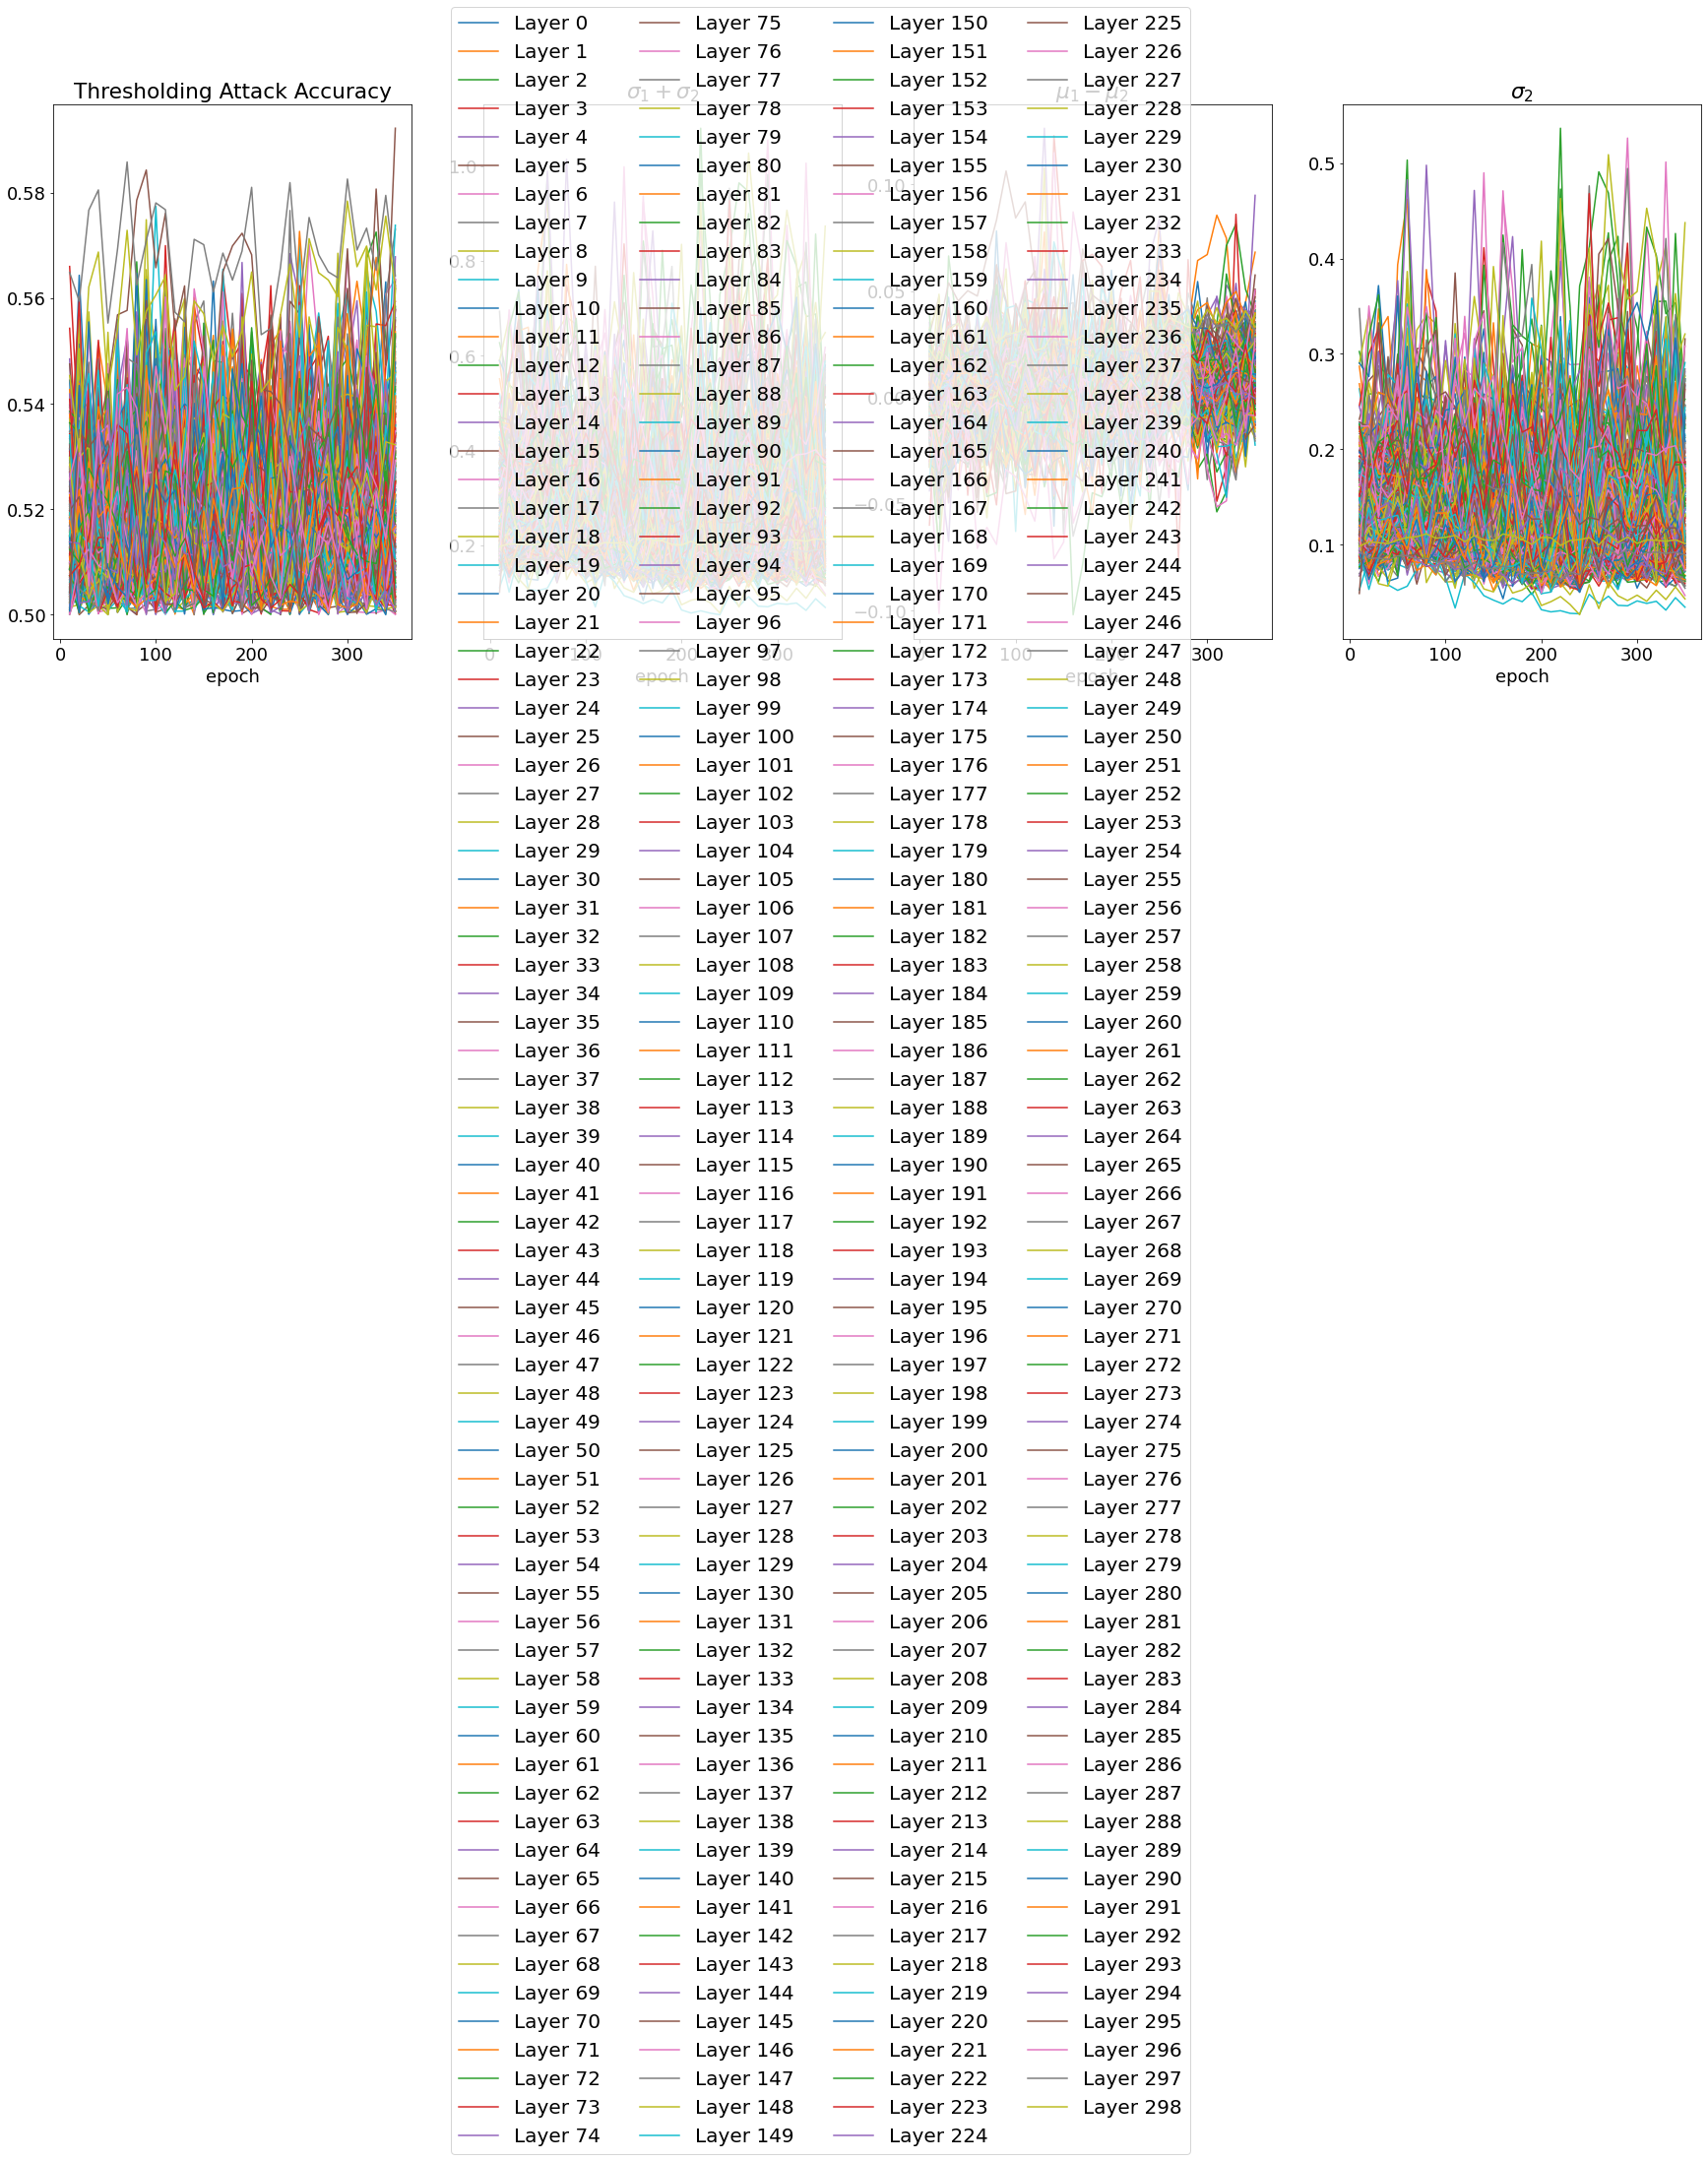

In [32]:
prefix = '/Users/jclialex/PycharmProjects/whiteboxmi_expdata/expdata/new_expdata/'
special_layers = np.arange(299)
epochs = (np.arange(35)+1)*10
all_analysis(epochs,prefix,'cifar100','densenet_cifar',200,num_user=10,target_data_size=2000,lr_mul=0.0,special_layers=special_layers,num_layers=299)